In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/Colab_Checkpoints.zip
!mv Colab_Checkpoints /content/drive/MyDrive

Archive:  /content/drive/MyDrive/Colab_Checkpoints.zip
  inflating: Colab_Checkpoints/LPD_UNET/LPD_UNET_30angles_neg30_pos30_noise0p01p0p5/lpd_unet_30angles_neg30_pos30_noise0p01p0p5.pth  
  inflating: Colab_Checkpoints/LPD_UNET/LPD_UNET_30angles_neg15_pos15_noise0p01p0p5/lpd_unet_30angles_neg15_pos15_noise0p01p0p5.pth  


In [3]:
!unzip /content/drive/MyDrive/MayoDataset.zip

Archive:  /content/drive/MyDrive/MayoDataset.zip
  inflating: Mayo_s Dataset/test/C081/307.png  
  inflating: Mayo_s Dataset/test/C081/303.png  
  inflating: Mayo_s Dataset/test/C081/321.png  
  inflating: Mayo_s Dataset/test/C081/315.png  
  inflating: Mayo_s Dataset/test/C081/300.png  
  inflating: Mayo_s Dataset/test/C081/290.png  
  inflating: Mayo_s Dataset/test/C081/314.png  
  inflating: Mayo_s Dataset/test/C081/288.png  
  inflating: Mayo_s Dataset/test/C081/301.png  
  inflating: Mayo_s Dataset/test/C081/323.png  
  inflating: Mayo_s Dataset/test/C081/322.png  
  inflating: Mayo_s Dataset/test/C081/312.png  
  inflating: Mayo_s Dataset/test/C081/298.png  
  inflating: Mayo_s Dataset/test/C081/316.png  
  inflating: Mayo_s Dataset/test/C081/310.png  
  inflating: Mayo_s Dataset/test/C081/309.png  
  inflating: Mayo_s Dataset/test/C081/313.png  
  inflating: Mayo_s Dataset/test/C081/308.png  
  inflating: Mayo_s Dataset/test/C081/318.png  
  inflating: Mayo_s Dataset/test/C081/3

In [4]:
!mv Mayo_s\ Dataset MajoDataset

In [5]:
import os
import shutil
from PIL import Image

# path alla cartella MajoDataset (modifica se serve)
root_dir = '/content/MajoDataset'

for split in ['train', 'test']:
    split_dir = os.path.join(root_dir, split)
    # scorri tutte le voci dentro train/ test
    for folder_name in os.listdir(split_dir):
        folder_path = os.path.join(split_dir, folder_name)
        if os.path.isdir(folder_path):
            # per ogni file nella sottocartella
            for fname in os.listdir(folder_path):
                src = os.path.join(folder_path, fname)
                # nuovo nome = nome della cartella + '_' + nome file
                new_fname = f"{folder_name}_{fname}"
                dst = os.path.join(split_dir, new_fname)
                # gestisci eventuali collisioni
                if os.path.exists(dst):
                    base, ext = os.path.splitext(new_fname)
                    i = 1
                    while True:
                        candidate = f"{base}_{i}{ext}"
                        candidate_path = os.path.join(split_dir, candidate)
                        if not os.path.exists(candidate_path):
                            dst = candidate_path
                            break
                        i += 1
                # sposta il file
                shutil.move(src, dst)

                # --- RESIZE DELL'IMMAGINE ---
                try:
                    with Image.open(dst) as img:
                        img = img.convert("RGB")  # garantiamo che sia RGB
                        img = img.resize((256, 256), Image.LANCZOS)
                        img.save(dst)
                except Exception as e:
                    print(f"Errore nel processare {dst}: {e}")

            # elimina la sottocartella vuota
            os.rmdir(folder_path)

print("Operazione completata! Tutti i file sono stati spostati, rinominati e resizzati a 256x256.")


Errore nel processare /content/MajoDataset/train/C027_C002 - Copia (4): [Errno 21] Is a directory: '/content/MajoDataset/train/C027_C002 - Copia (4)'
Operazione completata! Tutti i file sono stati spostati, rinominati e resizzati a 256x256.


In [6]:
# 1. (Opzionale) Disinstalla i pacchetti non necessari per ridurre conflitti
!pip uninstall -y thinc langchain-core

# 2. Reinstalla la versione compatibile di NumPy
!pip uninstall -y numpy
#!pip install "numpy==1.24.3"
#!pip install "scipy<1.13" # ODL needs older numpy/scipy currently

# 3. Installa le altre librerie
!pip install astra-toolbox torch torchvision torchaudio
!pip install https://github.com/adler-j/adler/archive/master.zip
!pip install jedi


!pip install scikit-image Pillow

# 4. (Opzionale) Forza il downgrade di packaging se langchain-core è necessario
!pip install packaging==24.0

# 5. Installa ODL forzando la reinstallazione
!pip install https://github.com/odlgroup/odl/archive/master.zip

!pip install opencv-python matplotlib pandas

!pip install https://github.com/devangelista2/IPPy/archive/master.zip #

#RERUN THE RUNTIME SESSION AFTER THESE OPERATIONS


Found existing installation: thinc 8.3.6
Uninstalling thinc-8.3.6:
  Successfully uninstalled thinc-8.3.6
Found existing installation: langchain-core 0.3.56
Uninstalling langchain-core-0.3.56:
  Successfully uninstalled langchain-core-0.3.56
Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.0 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
INFO: pip is looking at multiple version

In [2]:

import os, shutil
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import astra
import numpy as np
from PIL import Image
import cv2
import torch.nn.functional as F
import odl
#import odl.contrib.tensorflow
import torch.optim as optim
from skimage.metrics import peak_signal_noise_ratio as psnr # For evaluation metric
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
import random
import time
import traceback # For detailed error printin
from odl.contrib.torch import OperatorModule
import pandas as pd
from IPPy.nn import models

#codice con la Unet residuale "leggera" - CHECKPOINT COMPLETO SU DRIVE

In [3]:
# =============================================================================
# 1. #HYPERPARAMETERS AND INITIALIZATION
# =============================================================================

# --- MONTA GOOGLE DRIVE ---
try:
    from google.colab import drive
    drive.mount('/content/drive')
    drive_mounted = True
    print("Google Drive montato con successo.")
except ImportError:
    print("Google Colab 'drive' non trovato. Salverò localmente.")
    drive_mounted = False
except Exception as e:
    print(f"Errore durante il montaggio di Google Drive: {e}")
    drive_mounted = False


# --- Patch per ODL master ---
# Aggiunge l'import mancante nel modulo operator.py di odl.contrib.torch
try:
    # Accedi al modulo dove manca l'import
    module_to_patch = odl.contrib.torch.operator

    # Controlla se la variabile manca davvero prima di aggiungerla
    if not hasattr(module_to_patch, 'AVOID_UNNECESSARY_COPY'):
        # Importa la variabile dal posto giusto
        from odl.util.npy_compat import AVOID_UNNECESSARY_COPY

        # Aggiungi la variabile al namespace del modulo problematico
        module_to_patch.AVOID_UNNECESSARY_COPY = AVOID_UNNECESSARY_COPY
        print("Patch applicata: AVOID_UNNECESSARY_COPY aggiunta a odl.contrib.torch.operator")
    else:
         print("Patch non necessaria: AVOID_UNNECESSARY_COPY già presente in odl.contrib.torch.operator.")

    # Verifica opzionale se un'altra variabile usata lì vicino esiste
    if hasattr(module_to_patch, 'copy_if_zero_strides'):
         print("Verifica: 'copy_if_zero_strides' esiste in odl.contrib.torch.operator.")
    else:
         print("Attenzione: 'copy_if_zero_strides' sembra mancare in odl.contrib.torch.operator (potrebbe essere un altro problema).")


except ImportError as e_imp:
    print(f"Errore durante l'import per la patch: {e_imp}")
except AttributeError as e_attr:
     print(f"Errore durante l'applicazione della patch (attributo non trovato): {e_attr}")
except Exception as e_gen:
    print(f"Errore generico durante il tentativo di patch: {e_gen}")
# --- Fine Patch ---



# --- Device Configuration ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# =============================================================================
# 0. CONFIGURAZIONE DEL TRAINING RUN <<-- MODIFICA QUI !!
# =============================================================================
# Scegli la geometria: 'low_angle' o 'full_angle'
GEOMETRY_MODE = 'full_angle'  # o 'full_angle'

# Livello (frazione) di rumore DA APPLICARE *QUANDO* si aggiunge rumore
# (relativo a PROJ_MAX - PROJ_MIN)
NOISE_LEVEL_IF_APPLIED = 0.01 # Metti 0.0 se vuoi che anche i campioni rumorosi siano puliti (disabilita rumore)

# Probabilità (da 0.0 a 1.0) che un SINGOLO campione abbia rumore aggiunto
# 0.0 = tutti puliti
# 1.0 = tutti rumorosi (con livello NOISE_LEVEL_IF_APPLIED)
# 0.5 = circa metà puliti, metà rumorosi
NOISE_PROBABILITY = 0.5 # <--- NUOVO PARAMETRO

# --- Parametri Derivati dalla Configurazione ---
if GEOMETRY_MODE == 'low_angle':
    NUM_ANGLES_TRAIN = 30
    ANGLE_RANGE_DEG_TRAIN = [-30, 30]
    GEOMETRY_TAG = "30angles_neg30_pos30"
elif GEOMETRY_MODE == 'full_angle':
    NUM_ANGLES_TRAIN = 30 #con 180 mi va in out of memory
    ANGLE_RANGE_DEG_TRAIN = [-15, 15]
    GEOMETRY_TAG = "30angles_neg15_pos15"
else:
    raise ValueError("GEOMETRY_MODE deve essere 'low_angle' o 'full_angle'")

# Aggiorna il tag di configurazione per includere la probabilità
NOISE_TAG = f"noise{NOISE_LEVEL_IF_APPLIED:.2f}p{NOISE_PROBABILITY:.1f}".replace('.', 'p') # Es: noise0p01p0p5
CONFIG_NAME = f"{GEOMETRY_TAG}_{NOISE_TAG}"

print(f"--- CONFIGURAZIONE TRAINING RUN ---")
print(f"Geometria: {GEOMETRY_TAG}")
print(f"Livello Rumore (se applicato): {NOISE_LEVEL_IF_APPLIED}")
print(f"Probabilità Rumore per Campione: {NOISE_PROBABILITY}")
print(f"Configurazione ID: {CONFIG_NAME}")
print(f"------------------------------------")


# =============================================================================
# 1. CONFIGURATION
# =============================================================================
RECO_SIZE = 256
DETECTOR_PIXELS = int(RECO_SIZE * np.sqrt(2))

PROJ_MIN = 0.0
PROJ_MAX = 5.0  # Example maximum

# Calcolo dello standard deviation del rumore effettivo (usato QUANDO si aggiunge rumore)
NOISE_STD_DEV_ACTUAL = NOISE_LEVEL_IF_APPLIED * (PROJ_MAX - PROJ_MIN)
if NOISE_LEVEL_IF_APPLIED == 0.0:
    NOISE_STD_DEV_ACTUAL = 0.0 # Assicura sia esattamente 0
print(f"Actual noise std dev (when applied): {NOISE_STD_DEV_ACTUAL:.4f}")

# --- Parametri Modello e Training ---
N_ITER = 10
N_PRIMAL = 5
N_DUAL = 5
KERNEL_SIZE = (3, 3)
N_FEATURES = 4
UNET_DEPTH = 1

NUM_EPOCHS = 100 # Aumenta per training completo
STEPS_PER_EPOCH = 200 # Limita passi per epoca (utile per dataset grandi)
VALIDATION_STEPS = 50 # Limita passi di validazione
BATCH_SIZE = 16
LEARNING_RATE = 1e-4
CLIP_NORM = 1.0 # Valore massimo per il clipping della norma del gradiente
NUM_WORKERS = 0 # Mettere > 0 se possibile (es. 2 o 4) e non su Windows/macOS per caricamento dati parallelo


# --- PERCORSO CHECKPOINT SU DRIVE ---
# Modifica questo percorso secondo le tue preferenze su Google Drive
DRIVE_BASE_DIR  = '/content/drive/MyDrive/Colab_Checkpoints/LPD_UNET' # Esempio
CHECKPOINT_SUBDIR = f'LPD_UNET_{CONFIG_NAME}' # Sottocartella specifica
CHECKPOINT_FILENAME = f'lpd_unet_{CONFIG_NAME}.pth' # Nome file specifico

if drive_mounted:
    DRIVE_SAVE_DIR = os.path.join(DRIVE_BASE_DIR, CHECKPOINT_SUBDIR)
    try:
        os.makedirs(DRIVE_SAVE_DIR, exist_ok=True) # Crea directory se non esiste
        print(f"Saving checkpoints to Drive: {DRIVE_SAVE_DIR}")
        CHECKPOINT_PATH = os.path.join(DRIVE_SAVE_DIR, CHECKPOINT_FILENAME)
    except Exception as e:
        print(f"Warning: Could not create directory on Drive: {e}. Saving locally.")
        # Fallback a locale se creazione directory Drive fallisce
        CHECKPOINT_PATH = f'./{CHECKPOINT_FILENAME}'
else:
    # Salvataggio locale se Drive non è montato
    CHECKPOINT_PATH = f'./{CHECKPOINT_FILENAME}'

print(f"Checkpoint path set to: {CHECKPOINT_PATH}")

# =============================================================================
# 2. ODL SETUP & PyTorch wrappers (Usa parametri configurati)
# =============================================================================
print(f"--- Setting up ODL for Geometry: {GEOMETRY_TAG} ---")
# Calcola angoli in radianti
ANGLE_MIN_RAD_TRAIN = np.deg2rad(ANGLE_RANGE_DEG_TRAIN[0])
ANGLE_MAX_RAD_TRAIN = np.deg2rad(ANGLE_RANGE_DEG_TRAIN[1])

# Definisci spazi e geometria ODL
reco_space = odl.uniform_discr(
    [-RECO_SIZE/2]*2, [RECO_SIZE/2]*2, [RECO_SIZE, RECO_SIZE], dtype='float32'
)
angle_partition = odl.uniform_partition(
    ANGLE_MIN_RAD_TRAIN, ANGLE_MAX_RAD_TRAIN, NUM_ANGLES_TRAIN
)
detector_partition = odl.uniform_partition(
    -DETECTOR_PIXELS/2, DETECTOR_PIXELS/2, DETECTOR_PIXELS
)
geometry = odl.tomo.Parallel2dGeometry(angle_partition, detector_partition)
print(f"Geometry setup: {NUM_ANGLES_TRAIN} angles from {ANGLE_RANGE_DEG_TRAIN[0]}° to {ANGLE_RANGE_DEG_TRAIN[1]}°")
print(f"Detector pixels: {DETECTOR_PIXELS}")

# Crea operatori ODL RayTransform e Adjoint
# Gestione backend ASTRA (CUDA preferito, poi CPU, poi fallback ODL)
try:
    ray_trafo_odl = odl.tomo.RayTransform(reco_space, geometry, impl='astra_cuda')
    print("Using ASTRA CUDA backend.")
except Exception as e_cuda:
    print(f"ASTRA CUDA backend failed ({e_cuda}), trying ASTRA CPU...")
    try:
        ray_trafo_odl = odl.tomo.RayTransform(reco_space, geometry, impl='astra_cpu')
        print("Using ASTRA CPU backend.")
    except Exception as e_cpu:
        print(f"ASTRA CPU backend failed ({e_cpu}), falling back to ODL default implementation.")
        # ODL userà la sua implementazione (potrebbe essere lenta)
        ray_trafo_odl = odl.tomo.RayTransform(reco_space, geometry)

# Operatore aggiunto (Retroproiezione)
back_proj_odl = ray_trafo_odl.adjoint

# Crea wrapper PyTorch (usati dal modello LPD)
try:
    ray_trafo = OperatorModule(ray_trafo_odl).to(device)
    back_proj = OperatorModule(back_proj_odl).to(device)
    print("ODL operators wrapped for PyTorch.")
except Exception as e_wrap:
    print(f"!!! Error wrapping ODL operators for PyTorch: {e_wrap}")
    # Potrebbe indicare problemi di compatibilità ODL/PyTorch o memoria
    exit()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive montato con successo.
Patch applicata: AVOID_UNNECESSARY_COPY aggiunta a odl.contrib.torch.operator
Verifica: 'copy_if_zero_strides' esiste in odl.contrib.torch.operator.
--- CONFIGURAZIONE TRAINING RUN ---
Geometria: 30angles_neg15_pos15
Livello Rumore (se applicato): 0.01
Probabilità Rumore per Campione: 0.5
Configurazione ID: 30angles_neg15_pos15_noise0p01p0p5
------------------------------------
Actual noise std dev (when applied): 0.0500
Saving checkpoints to Drive: /content/drive/MyDrive/Colab_Checkpoints/LPD_UNET/LPD_UNET_30angles_neg15_pos15_noise0p01p0p5
Checkpoint path set to: /content/drive/MyDrive/Colab_Checkpoints/LPD_UNET/LPD_UNET_30angles_neg15_pos15_noise0p01p0p5/lpd_unet_30angles_neg15_pos15_noise0p01p0p5.pth
--- Setting up ODL for Geometry: 30angles_neg15_pos15 ---
Geometry setup: 30 angles from -15° to 15°
Detector pixels: 362


In [ ]:
# =============================================================================
# 3. NETWORK DEFINITION (Residual U-Net e LPD)
# =============================================================================
# --- Blocchi U-Net ---
'''
class ConvBlock(nn.Module):
    """Blocco convoluzionale base: Conv -> PReLU -> Conv -> PReLU"""
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, KERNEL_SIZE, padding='same')
        self.prelu1 = nn.PReLU(out_ch) # Attivazione parametrica
        self.conv2 = nn.Conv2d(out_ch, out_ch, KERNEL_SIZE, padding='same')
        self.prelu2 = nn.PReLU(out_ch)
        # Inizializzazione Kaiming per pesi, zero per bias
        for layer in [self.conv1, self.conv2]:
            nn.init.kaiming_normal_(layer.weight, nonlinearity='leaky_relu')
            if layer.bias is not None:
                nn.init.zeros_(layer.bias)

    def forward(self, x):
        x = self.prelu1(self.conv1(x))
        x = self.prelu2(self.conv2(x))
        return x

class DownBlock(nn.Module):
    """Blocco di downsampling: MaxPool -> ConvBlock"""
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.pool = nn.MaxPool2d(2)
        self.conv_block = ConvBlock(in_ch, out_ch)

    def forward(self, x):
        x = self.pool(x)
        x = self.conv_block(x)
        return x

class UpBlock(nn.Module):
    """Blocco di upsampling: Upsample/ConvTranspose -> Concat(skip) -> ConvBlock"""
    def __init__(self, in_ch, skip_ch, out_ch, use_transpose_conv=False):
        super().__init__()
        self.use_transpose_conv = use_transpose_conv
        up_out_ch = in_ch // 2 # Canali dopo upsampling prima della concatenazione

        if self.use_transpose_conv:
            # Opzione 1: ConvTranspose2d
            self.up = nn.ConvTranspose2d(in_ch, up_out_ch, kernel_size=2, stride=2)
            nn.init.kaiming_normal_(self.up.weight, nonlinearity='leaky_relu')
            if self.up.bias is not None: nn.init.zeros_(self.up.bias)
        else:
            # Opzione 2: Upsample Bilineare + Conv 1x1
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv1x1 = nn.Conv2d(in_ch, up_out_ch, kernel_size=1)
            nn.init.kaiming_normal_(self.conv1x1.weight, nonlinearity='leaky_relu')
            if self.conv1x1.bias is not None: nn.init.zeros_(self.conv1x1.bias)

        # Blocco convoluzionale dopo la concatenazione
        concat_ch = up_out_ch + skip_ch # Canali totali dopo concatenazione
        self.conv_block = ConvBlock(concat_ch, out_ch)

    def forward(self, x, skip):
        # Applica upsampling
        x_up = self.up(x)
        if not self.use_transpose_conv:
            x_up = self.conv1x1(x_up)

        # Gestisce eventuali differenze di dimensione spaziale dovute a padding/pooling
        # (potrebbe non essere necessario con padding='same' e stride=2)
        diffY = skip.size()[2] - x_up.size()[2]
        diffX = skip.size()[3] - x_up.size()[3]
        if diffX != 0 or diffY != 0:
            # Applica padding per far combaciare le dimensioni
            x_up = F.pad(x_up, [diffX // 2, diffX - diffX // 2,
                                diffY // 2, diffY - diffY // 2])

        # Concatena con la skip connection e passa al blocco convoluzionale
        x_concat = torch.cat([skip, x_up], dim=1)
        return self.conv_block(x_concat)

class ResidualUNetLight(nn.Module):
    """U-Net Leggera con Connessioni Residuali sull'output."""
    def __init__(self, in_ch, out_ch, n_features_base=N_FEATURES, depth=UNET_DEPTH):
        super().__init__()
        if depth < 0: raise ValueError("Depth must be >= 0")
        self.in_ch = in_ch
        self.out_ch = out_ch
        self.depth = depth

        # Blocco iniziale
        self.inc = ConvBlock(in_ch, n_features_base)

        # Encoder (Down Blocks)
        self.down_blocks = nn.ModuleList()
        encoder_features = [] # Lista per memorizzare feature per skip connections
        features = n_features_base
        encoder_features.append(features) # Feature dopo inc
        for _ in range(depth):
            self.down_blocks.append(DownBlock(features, features * 2))
            features *= 2
            encoder_features.append(features) # Feature dopo ogni down block

        # Bottleneck
        self.bottleneck = ConvBlock(features, features * 2)
        features_bneck_out = features * 2

        # Decoder (Up Blocks)
        self.up_blocks = nn.ModuleList()
        features_up = features_bneck_out
        for i in range(depth):
            features_skip = encoder_features[-(i + 2)] # Prende le feature dalla lista invertita
            features_out_up = features_up // 2 # Dimezza i canali ad ogni step up
            self.up_blocks.append(UpBlock(features_up, features_skip, features_out_up))
            features_up = features_out_up

        # Convoluzione finale 1x1 per mappare all'output desiderato
        self.outc = nn.Conv2d(features_up, out_ch, kernel_size=1)
        # Inizializzazione specifica per il layer di output (piccola std dev)
        nn.init.normal_(self.outc.weight, mean=0, std=0.01)
        if self.outc.bias is not None: nn.init.zeros_(self.outc.bias)

    def forward(self, x):
        # Gestione input residuale (se i primi 'out_ch' canali di input devono essere sommati all'output)
        # Controlla se l'input ha abbastanza canali per fornire il residuale
        residual_input = x[:, :self.out_ch] if x.shape[1] >= self.out_ch else None

        # --- Encoder ---
        encoders_output = []
        xi = self.inc(x)
        encoders_output.append(xi)
        for i in range(self.depth):
            xi = self.down_blocks[i](xi)
            encoders_output.append(xi)

        # --- Bottleneck ---
        x_b = self.bottleneck(encoders_output[-1])

        # --- Decoder ---
        x_up = x_b
        for i in range(self.depth):
            # Prende la skip connection corrispondente dall'encoder
            skip_connection = encoders_output[-(i + 2)]
            x_up = self.up_blocks[i](x_up, skip_connection)

        # --- Output ---
        update = self.outc(x_up)

        # --- Connessione Residuale ---
        # Somma l'input (se disponibile e le dimensioni combaciano) all'update
        if residual_input is not None and residual_input.shape == update.shape:
             output = residual_input + update
        else:
             # Se non c'è input residuale o le dimensioni non combaciano, ritorna solo l'update
             if residual_input is not None and residual_input.shape != update.shape:
                  print(f"Warning: Residual shape mismatch. Input: {residual_input.shape}, Update: {update.shape}. Returning update only.")
             output = update
        return output
        '''

'\nclass ConvBlock(nn.Module):\n    """Blocco convoluzionale base: Conv -> PReLU -> Conv -> PReLU"""\n    def __init__(self, in_ch, out_ch):\n        super().__init__()\n        self.conv1 = nn.Conv2d(in_ch, out_ch, KERNEL_SIZE, padding=\'same\')\n        self.prelu1 = nn.PReLU(out_ch) # Attivazione parametrica\n        self.conv2 = nn.Conv2d(out_ch, out_ch, KERNEL_SIZE, padding=\'same\')\n        self.prelu2 = nn.PReLU(out_ch)\n        # Inizializzazione Kaiming per pesi, zero per bias\n        for layer in [self.conv1, self.conv2]:\n            nn.init.kaiming_normal_(layer.weight, nonlinearity=\'leaky_relu\')\n            if layer.bias is not None:\n                nn.init.zeros_(layer.bias)\n\n    def forward(self, x):\n        x = self.prelu1(self.conv1(x))\n        x = self.prelu2(self.conv2(x))\n        return x\n\nclass DownBlock(nn.Module):\n    """Blocco di downsampling: MaxPool -> ConvBlock"""\n    def __init__(self, in_ch, out_ch):\n        super().__init__()\n        self.

In [4]:
# =============================================================================
# 4. PRIMAL DUAL NET DEFINITION
# =============================================================================

# Importa i modelli IPPy all'inizio del tuo script, vicino agli altri import
try:
    from IPPy.nn import models
    print("Libreria IPPy importata con successo.")
except ImportError:
    print("!!! ERRORE: Libreria IPPy non trovata. Assicurati che sia installata correttamente.")
    # Potresti voler fermare l'esecuzione se IPPy è necessaria
    exit()
# ... (altri import come nn, ecc.)

# =============================================================================
# 4. PRIMAL DUAL NET DEFINITION (MODIFICATO)
# =============================================================================
class LearnedPrimalDualNet(nn.Module):
    """Implementazione della rete Learned Primal-Dual usando IPPy.nn.models.UNet."""
    def __init__(self):
        super().__init__()
        # Definisce i canali di input per le reti duali e primali (come prima)
        dual_in_channels = N_DUAL + 2
        primal_in_channels = N_PRIMAL + 1

        # --- Configura i parametri per IPPy UNet ---
        # Questi parametri definiscono la complessità della UNet.
        # Devi adattarli per essere simili alla tua UNet originale
        # (N_FEATURES=16, UNET_DEPTH=1) o usare quelli dell'esempio IPPy.

        # OPZIONE 1: Cerca di imitare la tua UNet originale (Depth=1)
        # middle_ch: Canali dopo il primo blocco conv e dopo ogni down block.
        # Per depth=1, potremmo avere [N_FEATURES, N_FEATURES*2]? O solo [N_FEATURES]?
        # Proviamo con una configurazione semplice simile a depth=1
        ippy_middle_ch = [N_FEATURES, N_FEATURES * 2] # Es: [16, 32]  <--- MODIFICA QUI
        ippy_down_layers = ["ResDownBlock"] # 1 blocco down
        ippy_up_layers = ["ResUpBlock"] # 1 blocco up
        ippy_n_layers_per_block = 2 # Numero di Conv per blocco (come nell'esempio IPPy)

        # OPZIONE 2: Usa la configurazione dell'esempio IPPy (Depth=2)
        # ippy_middle_ch=[64, 128, 256]
        # ippy_down_layers=("ResDownBlock", "ResDownBlock")
        # ippy_up_layers=("ResUpBlock", "ResUpBlock")
        # ippy_n_layers_per_block=2

        # ---> SCEGLI UNA DELLE DUE OPZIONI o definiscine una tua <---
        print(f"Configurazione IPPy UNet: middle_ch={ippy_middle_ch}, "
              f"down_layers={ippy_down_layers}, up_layers={ippy_up_layers}, "
              f"n_layers_per_block={ippy_n_layers_per_block}")

        # Crea N_ITER reti U-Net DUALI usando IPPy
        self.dual_nets = nn.ModuleList([
            models.UNet(ch_in=dual_in_channels,
                        ch_out=N_DUAL, # Output deve avere N_DUAL canali
                        middle_ch=ippy_middle_ch,
                        n_layers_per_block=ippy_n_layers_per_block,
                        down_layers=ippy_down_layers,
                        up_layers=ippy_up_layers,
                        final_activation=None) # Come nell'esempio IPPy
            for _ in range(N_ITER)
        ])

        # Crea N_ITER reti U-Net PRIMALI usando IPPy
        self.primal_nets = nn.ModuleList([
            models.UNet(ch_in=primal_in_channels,
                        ch_out=N_PRIMAL, # Output deve avere N_PRIMAL canali
                        middle_ch=ippy_middle_ch, # Stessa architettura delle duali
                        n_layers_per_block=ippy_n_layers_per_block,
                        down_layers=ippy_down_layers,
                        up_layers=ippy_up_layers,
                        final_activation=None)
            for _ in range(N_ITER)
        ])

    # --- Il metodo forward rimane IDENTICO a prima ---
    # Si assume che la IPPy UNet faccia la cosa giusta internamente
    def forward(self, g, ray_trafo_op=ray_trafo, back_proj_op=back_proj):
        """
        Forward pass della rete LPD.
        Args:
            g (torch.Tensor): Sinogramma di input (Batch, 1, H_sino, W_sino).
            ray_trafo_op (OperatorModule): Operatore forward (K).
            back_proj_op (OperatorModule): Operatore adjoint (K*).
        Returns:
            torch.Tensor: Immagine ricostruita (Batch, 1, H_reco, W_reco).
        """
        g_normalized = (g * 2.0) - 1.0
        batch_size = g_normalized.shape[0]

        prim_shape = (batch_size, N_PRIMAL, RECO_SIZE, RECO_SIZE)
        prim = torch.zeros(prim_shape, device=g.device)

        dual_shape = (batch_size, N_DUAL) + g_normalized.shape[-2:]
        dual = torch.zeros(dual_shape, device=g.device)

        for i in range(N_ITER):
            # --- Passo Aggiornamento Duale ---
            try:
                if N_PRIMAL < 2: raise ValueError("N_PRIMAL must be >= 2 for prim[:, 1:2] access")
                op_eval = ray_trafo_op(prim[:, 1:2]) # Shape: (B, 1, Hs, Ws)
                dual_input = torch.cat([dual, op_eval, g_normalized], dim=1) # Shape: (B, N_DUAL+1+1, Hs, Ws)

                # Chiama la UNet di IPPy
                dual = self.dual_nets[i](dual_input) # Shape: (B, N_DUAL, Hs, Ws)

            except Exception as e:
                # ... (codice di gestione errore come prima) ...
                print(f"\n!!! Error in LPD Dual Step Iteration {i+1} (using IPPy UNet): {e}")
                # ... (stampa shapes) ...
                raise e

            # --- Passo Aggiornamento Primale ---
            try:
                bp_eval = back_proj_op(dual[:, 0:1]) # Shape: (B, 1, Hr, Wr)
                primal_input = torch.cat([prim, bp_eval], dim=1) # Shape: (B, N_PRIMAL+1, Hr, Wr)

                # Chiama la UNet di IPPy
                prim = self.primal_nets[i](primal_input) # Shape: (B, N_PRIMAL, Hr, Wr)

            except Exception as e:
                 # ... (codice di gestione errore come prima) ...
                 print(f"\n!!! Error in LPD Primal Step Iteration {i+1} (using IPPy UNet): {e}")
                 # ... (stampa shapes) ...
                 raise e

        final_reconstruction = prim[:, 0:1] # Shape: (B, 1, Hr, Wr)
        return final_reconstruction

# ASSICURATI DI RIMUOVERE O COMMENTARE LA TUA VECCHIA DEFINIZIONE DI
# ConvBlock, DownBlock, UpBlock, ResidualUNetLight
# perché non verranno più usate da LearnedPrimalDualNet.
'''
class LearnedPrimalDualNet(nn.Module):
    """Implementazione della rete Learned Primal-Dual."""
    def __init__(self):
        super().__init__()
        # Definisce i canali di input per le reti duali e primali
        # Dual Input: stato duale (N_DUAL) + K(x) (1) + g (1) = N_DUAL + 2 ?
        # --> Il codice originale usa N_DUAL + 2, assumendo g sia normalizzato a [-1, 1] e K(x) abbia 1 canale
        # Primal Input: stato primale (N_PRIMAL) + K*(y) (1) = N_PRIMAL + 1
        dual_in_channels = N_DUAL + 2
        primal_in_channels = N_PRIMAL + 1

        # Crea N_ITER reti U-Net per lo spazio duale
        self.dual_nets = nn.ModuleList([
            ResidualUNetLight(dual_in_channels, N_DUAL, n_features_base=N_FEATURES, depth=UNET_DEPTH)
            for _ in range(N_ITER)
        ])
        # Crea N_ITER reti U-Net per lo spazio primale
        self.primal_nets = nn.ModuleList([
            ResidualUNetLight(primal_in_channels, N_PRIMAL, n_features_base=N_FEATURES, depth=UNET_DEPTH)
            for _ in range(N_ITER)
        ])

    def forward(self, g, ray_trafo_op=ray_trafo, back_proj_op=back_proj): # <-- Aggiungi operatori qui
        """
        Forward pass della rete LPD.
        Args:
            g (torch.Tensor): Sinogramma di input (Batch, 1, H_sino, W_sino).
            ray_trafo_op (OperatorModule): Operatore forward (K) specifico per la geometria di g.
            back_proj_op (OperatorModule): Operatore adjoint (K*) specifico per la geometria di g.
        Returns:
            torch.Tensor: Immagine ricostruita (Batch, 1, H_reco, W_reco).
        """
        g_normalized = (g * 2.0) - 1.0
        batch_size = g_normalized.shape[0]

        prim_shape = (batch_size, N_PRIMAL, RECO_SIZE, RECO_SIZE)
        prim = torch.zeros(prim_shape, device=g.device)

        dual_shape = (batch_size, N_DUAL) + g_normalized.shape[-2:]
        dual = torch.zeros(dual_shape, device=g.device)

        for i in range(N_ITER):
            # --- Passo Aggiornamento Duale ---
            try:
                if N_PRIMAL < 2: raise ValueError("N_PRIMAL must be >= 2 for prim[:, 1:2] access")
                # Usa l'operatore passato come argomento
                op_eval = ray_trafo_op(prim[:, 1:2]) # Shape: (B, 1, Hs, Ws)

                # Verifica shape prima della concatenazione (debug)
                # print(f"Iter {i+1} Dual - dual: {dual.shape}, op_eval: {op_eval.shape}, g_norm: {g_normalized.shape}")

                dual_input = torch.cat([dual, op_eval, g_normalized], dim=1) # Shape: (B, N_DUAL+1+1, Hs, Ws)
                dual = self.dual_nets[i](dual_input) # Shape: (B, N_DUAL, Hs, Ws)

            except Exception as e:
                # Stampa forme per debug
                print(f"\n!!! Error in LPD Dual Step Iteration {i+1}: {e}")
                current_op_eval_shape = "N/A"
                try: current_op_eval_shape = op_eval.shape
                except: pass
                current_dual_input_shape = "N/A"
                try: current_dual_input_shape = dual_input.shape
                except: pass
                print(f"Shapes - dual: {dual.shape}, op_eval: {current_op_eval_shape}, g_norm: {g_normalized.shape}, dual_input: {current_dual_input_shape}")
                raise e # Ferma

            # --- Passo Aggiornamento Primale ---
            try:
                # Usa l'operatore passato come argomento
                bp_eval = back_proj_op(dual[:, 0:1]) # Shape: (B, 1, Hr, Wr)

                # Verifica shape prima della concatenazione (debug)
                # print(f"Iter {i+1} Primal - prim: {prim.shape}, bp_eval: {bp_eval.shape}")

                primal_input = torch.cat([prim, bp_eval], dim=1) # Shape: (B, N_PRIMAL+1, Hr, Wr)
                prim = self.primal_nets[i](primal_input) # Shape: (B, N_PRIMAL, Hr, Wr)

            except Exception as e:
                 # Stampa forme per debug
                print(f"\n!!! Error in LPD Primal Step Iteration {i+1}: {e}")
                current_bp_eval_shape = "N/A"
                try: current_bp_eval_shape = bp_eval.shape
                except: pass
                current_primal_input_shape = "N/A"
                try: current_primal_input_shape = primal_input.shape
                except: pass
                print(f"Shapes - prim: {prim.shape}, bp_eval: {current_bp_eval_shape}, primal_input: {current_primal_input_shape}")
                raise e # Ferma

        final_reconstruction = prim[:, 0:1] # Shape: (B, 1, Hr, Wr)
        return final_reconstruction
        '''

Libreria IPPy importata con successo.


'\nclass LearnedPrimalDualNet(nn.Module):\n    """Implementazione della rete Learned Primal-Dual."""\n    def __init__(self):\n        super().__init__()\n        # Definisce i canali di input per le reti duali e primali\n        # Dual Input: stato duale (N_DUAL) + K(x) (1) + g (1) = N_DUAL + 2 ?\n        # --> Il codice originale usa N_DUAL + 2, assumendo g sia normalizzato a [-1, 1] e K(x) abbia 1 canale\n        # Primal Input: stato primale (N_PRIMAL) + K*(y) (1) = N_PRIMAL + 1\n        dual_in_channels = N_DUAL + 2\n        primal_in_channels = N_PRIMAL + 1\n\n        # Crea N_ITER reti U-Net per lo spazio duale\n        self.dual_nets = nn.ModuleList([\n            ResidualUNetLight(dual_in_channels, N_DUAL, n_features_base=N_FEATURES, depth=UNET_DEPTH)\n            for _ in range(N_ITER)\n        ])\n        # Crea N_ITER reti U-Net per lo spazio primale\n        self.primal_nets = nn.ModuleList([\n            ResidualUNetLight(primal_in_channels, N_PRIMAL, n_features_base=N_FE

In [5]:

# =============================================================================
# 5. DATASET & DataLoader (MODIFICATO per rumore probabilistico)
# =============================================================================
class MayoPngDataset(Dataset):
    """
    Dataset per caricare immagini PNG ground truth, generare sinogrammi
    al volo con una data geometria ODL e aggiungere rumore probabilisticamente.
    """
    def __init__(self, data_dir, oodl_reco_space, oodl_ray_transformer,
                 noise_probability=0.0, # Probabilità di aggiungere rumore
                 noise_std_dev=0.0,     # Std dev del rumore QUANDO viene aggiunto
                 proj_min=0.0, proj_max=5.0, reco_size=256):
        """
        Args:
            data_dir (str): Directory con le immagini PNG ground truth.
            oodl_reco_space (odl.DiscretizedSpace): Spazio di ricostruzione ODL.
            oodl_ray_transformer (odl.Operator): Operatore RayTransform ODL (già configurato).
            noise_probability (float): Probabilità [0, 1] che venga aggiunto rumore a un campione.
            noise_std_dev (float): Standard deviation del rumore Gaussiano da aggiungere
                                   QUANDO la probabilità lo decide (basato su PROJ_MIN/MAX).
            proj_min (float): Valore minimo atteso del sinogramma fisico (per normalizzazione).
            proj_max (float): Valore massimo atteso del sinogramma fisico (per normalizzazione).
            reco_size (int): Dimensione lato immagine (es. 256).
        """
        self.files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.lower().endswith('.png')]
        if not self.files:
             print(f"Warning: No PNG files found in directory {data_dir}")
             # raise FileNotFoundError(f"No PNG files found in directory {data_dir}") # Alternativa più severa
        self.reco_space = oodl_reco_space
        self.ray_trafo = oodl_ray_transformer # Usa l'operatore ODL passato
        self.noise_probability = noise_probability
        self.noise_std_dev = noise_std_dev
        self.proj_min = proj_min
        self.proj_max = proj_max
        self.reco_size = reco_size
        print(f"Dataset initialized for {data_dir}.")
        print(f" -> Using ODL operator: {self.ray_trafo}")
        print(f" -> Configured with noise probability: {self.noise_probability:.2f}")
        if self.noise_probability > 0 and self.noise_std_dev > 0:
             print(f" -> Noise std dev (when applied): {self.noise_std_dev:.4f}")
        elif self.noise_probability > 0 and self.noise_std_dev == 0:
             print(f" -> Noise probability > 0 but std dev is 0. No noise will be added.")
        else:
             print(f" -> No noise will be added (probability is 0).")


    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        """Carica GT, genera sinogramma, aggiunge rumore (prob), normalizza."""
        file_path = self.files[idx]
        try:
            # 1. Carica e normalizza Ground Truth [0, 1]
            img = Image.open(file_path).convert('L').resize((self.reco_size, self.reco_size), Image.Resampling.LANCZOS)
            arr_gt = np.array(img, dtype=np.float32)
            gt_min, gt_max = arr_gt.min(), arr_gt.max()
            # Gestisce immagini costanti e normalizza
            if gt_max - gt_min < 1e-8:
                arr_gt.fill(0.0)
            else:
                arr_gt = (arr_gt - gt_min) / (gt_max - gt_min) # GT in [0, 1]

            # Controlla NaN/Inf in GT
            if np.isnan(arr_gt).any() or np.isinf(arr_gt).any():
                 print(f"Warning: NaN/Inf in ground truth image {file_path}. Skipping.")
                 return None # Ritorna None per essere filtrato da collate_fn

            # 2. Genera Sinogramma usando l'operatore ODL corretto
            odl_phantom = self.reco_space.element(arr_gt)
            # Esegui Ray Transform
            sinogram = self.ray_trafo(odl_phantom).asarray().astype(np.float32)

            # 3. Aggiungi Rumore PROBABILISTICAMENTE (al sinogramma fisico)
            # Decide se aggiungere rumore basandosi sulla probabilità
            add_noise_this_time = (np.random.rand() < self.noise_probability) and (self.noise_std_dev > 0)
            if add_noise_this_time:
                # Genera rumore Gaussiano con lo std dev specificato
                noise = np.random.normal(0, self.noise_std_dev, sinogram.shape).astype(np.float32)
                sinogram += noise

            # 4. Normalizza Sinogramma a [0, 1] usando PROJ_MIN, PROJ_MAX
            sg_min, sg_max = self.proj_min, self.proj_max
            if sg_max - sg_min < 1e-8: # Evita divisione per zero se il range è nullo
                sinogram_normalized = np.zeros_like(sinogram)
            else:
                sinogram_normalized = (sinogram - sg_min) / (sg_max - sg_min)

            # 5. Clip a [0, 1] e Controllo NaN/Inf finale sul sinogramma normalizzato
            sinogram_normalized = np.clip(sinogram_normalized, 0.0, 1.0)
            if np.isnan(sinogram_normalized).any() or np.isinf(sinogram_normalized).any():
                print(f"Warning: NaN/Inf in final normalized sinogram for {file_path}. Skipping.")
                return None # Filtra questo campione

            # 6. Ritorna tensori PyTorch (Aggiungi dimensione canale C=1)
            sino_tensor = torch.from_numpy(sinogram_normalized).unsqueeze(0) # Shape: (1, Hs, Ws)
            gt_tensor = torch.from_numpy(arr_gt).unsqueeze(0)           # Shape: (1, Hr, Wr)
            return sino_tensor, gt_tensor

        except FileNotFoundError:
             print(f"Error: File not found {file_path}. Skipping.")
             return None
        except Exception as e:
            # Stampa errore dettagliato per debug
            print(f"!!! Unhandled Error processing file {file_path}: {e}")
            import traceback
            traceback.print_exc() # Stampa il traceback completo
            return None # Salta questo campione problematico

def collate_skip_none(batch):
    """
    Collate function per DataLoader che filtra i campioni 'None'
    restituiti dal Dataset in caso di errori.
    """
    # Filtra via tutti gli elementi None nel batch
    filtered_batch = [b for b in batch if b is not None]

    # Se dopo il filtraggio il batch è vuoto, ritorna None
    if not filtered_batch:
        return None

    # Altrimenti, usa la funzione di collate di default di PyTorch sul batch filtrato
    # Questo combinerà correttamente le tuple (sinogramma, gt) in batch di tensori
    return torch.utils.data.default_collate(filtered_batch)


In [ ]:
# =============================================================================
# 7. TRAINING
# =============================================================================



# --- Istanziazione Dataset e DataLoader (Passa parametri configurati) ---
train_data_dir = os.path.join('MajoDataset','train')
test_data_dir = os.path.join('MajoDataset','test')
# Controlla se le directory esistono prima di creare i dataset
if not os.path.isdir(train_data_dir): raise FileNotFoundError(f"Directory di training non trovata: {train_data_dir}")
if not os.path.isdir(test_data_dir): raise FileNotFoundError(f"Directory di test non trovata: {test_data_dir}")


# Passa l'operatore ODL corretto, la PROBABILITA' di rumore e lo STD DEV (quando applicato)
train_ds = MayoPngDataset(train_data_dir, reco_space, ray_trafo_odl,
                          noise_probability=NOISE_PROBABILITY, # Probabilità
                          noise_std_dev=NOISE_STD_DEV_ACTUAL,  # Std Dev (se prob>0)
                          proj_min=PROJ_MIN, proj_max=PROJ_MAX, reco_size=RECO_SIZE)

# Per la validazione, spesso si preferisce una condizione fissa (es. sempre rumoroso o sempre pulito)
# per metriche stabili. Qui usiamo la stessa probabilità del training. Modifica se necessario.
# Esempio: validazione sempre rumorosa (se NOISE_STD_DEV_ACTUAL > 0): noise_probability=1.0
# Esempio: validazione sempre pulita: noise_probability=0.0
val_ds = MayoPngDataset(test_data_dir, reco_space, ray_trafo_odl,
                        noise_probability=NOISE_PROBABILITY, # Stessa probabilità del training
                        noise_std_dev=NOISE_STD_DEV_ACTUAL,
                        proj_min=PROJ_MIN, proj_max=PROJ_MAX, reco_size=RECO_SIZE)

# Test rapido per vedere se i dataset caricano almeno un campione
try:
    print("Testing dataset sample loading...")
    train_sample = train_ds[0] if len(train_ds) > 0 else None
    val_sample = val_ds[0] if len(val_ds) > 0 else None
    if train_sample is None and len(train_ds) > 0:
         print("Warning: Failed to load first sample from training dataset (returned None).")
    if val_sample is None and len(val_ds) > 0:
         print("Warning: Failed to load first sample from validation dataset (returned None).")
    if len(train_ds) == 0 or len(val_ds) == 0:
        raise ValueError("Training or Validation dataset is empty. Check data paths and file integrity.")
    print(f"Dataset lengths: Train={len(train_ds)}, Validation={len(val_ds)}")
    print("Sample loading test completed (may have warnings if first sample failed).")
except Exception as e:
     print(f"!!! Error during dataset initialization or sample loading test: {e}")
     print("!!! Check file paths, permissions, ODL/ASTRA setup, and PNG file validity.")
     exit() # Interrompe lo script se i dataset non sono utilizzabili


# Creazione DataLoaders
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, collate_fn=collate_skip_none,
                          pin_memory=True if device.type == 'cuda' else False,
                          persistent_workers=True if NUM_WORKERS > 0 else False) # Opzionale per velocità
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, collate_fn=collate_skip_none,
                          pin_memory=True if device.type == 'cuda' else False,
                          persistent_workers=True if NUM_WORKERS > 0 else False)
print(f"DataLoaders created (Batch size: {BATCH_SIZE}, Num workers: {NUM_WORKERS}).")


# =============================================================================
# 6. TRAIN & EVAL FUNCTIONS
# =============================================================================

# --- Istanziazione Modello e Test Forward Pass ---
model = LearnedPrimalDualNet().to(device)
print(f"Model '{model.__class__.__name__}' instantiated on device: {device}")
try:
    print("Testing model forward pass with dummy data...")
    # Crea un sinogramma dummy con le dimensioni corrette basate sulla geometria
    # Usa le dimensioni effettive dell'output dell'operatore ODL se disponibili
    dummy_sino_shape = (2, 1) + ray_trafo_odl.range.shape # (Batch, Canali, H_sino, W_sino)
    dummy_sino = torch.randn(dummy_sino_shape, device=device)
    print(f"Dummy sinogram shape: {dummy_sino.shape}")
    _ = model(dummy_sino) # Esegui forward pass
    print("Model forward pass test successful.")
except Exception as e:
    print(f"!!! Error during model forward pass test: {e}")
    print("!!! Check model architecture, input/output shapes, and OperatorModule setup.")
    exit()

# Conta parametri allenabili
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {num_params / 1e6:.2f} M")


# --- Loss, Optimizer, Scheduler ---
criterion = nn.SmoothL1Loss() # Loss L1 Regolarizzata (meno sensibile a outliers di L2)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5) # Adam con weight decay
# Scheduler per ridurre il learning rate quando la validation loss smette di migliorare
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)


# --- Funzione per Calcolare Norma Gradiente ---
def grad_norm(model):
    """Calcola la norma L2 totale dei gradienti del modello."""
    total_norm_sq = 0.0
    count = 0
    for p in model.parameters():
        if p.grad is not None:
            # Calcola norma L2 al quadrato del gradiente del parametro
            param_norm_sq = p.grad.data.norm(2)**2
            # Somma solo se il valore è valido (non NaN, non Infinito)
            if not torch.isnan(param_norm_sq) and not torch.isinf(param_norm_sq):
                total_norm_sq += param_norm_sq
                count += 1
            else:
                # Log opzionale per identificare parametri con gradienti problematici
                # print(f"Warning: NaN/Inf gradient norm in parameter (shape {p.shape})")
                pass
    # Ritorna la radice quadrata della somma delle norme al quadrato
    return total_norm_sq**0.5 if total_norm_sq > 0 else torch.tensor(0.0, device=device)


# --- Funzione di Training per un'Epoca ---
def train_one_epoch():
    """Esegue un'epoca di training."""
    model.train() # Imposta il modello in modalità training
    running_loss = 0.0
    total_samples = 0
    start_time = time.time()
    skipped_batches = 0
    batches_processed = 0

    for i, batch_data in enumerate(train_loader):
        # Salta il batch se collate_fn ha restituito None (tutti campioni falliti)
        if batch_data is None:
            # print(f"Skipping batch {i+1} due to collation failure.")
            skipped_batches += 1
            continue

        # Estrai sinogramma (g) e ground truth (target) dal batch
        g, target = batch_data
        if g is None or target is None: # Controllo di sicurezza aggiuntivo
             skipped_batches += 1; continue

        # Sposta i dati sul device corretto (GPU o CPU)
        g, target = g.to(device), target.to(device)
        current_batch_size = g.size(0)
        total_samples += current_batch_size

        # Azzera i gradienti dell'ottimizzatore
        optimizer.zero_grad()

        try:
            # Forward pass: calcola l'output del modello
            out = model(g)
            # Calcola la loss tra output e target
            loss = criterion(out, target)
            # Backward pass: calcola i gradienti
            loss.backward()
            # Calcola la norma dei gradienti PRIMA del clipping/step
            gn = grad_norm(model)

        except Exception as e:
            # Gestione errori durante forward/backward pass
            print(f"\n!!! Error during training batch {i+1} (Size: {current_batch_size}): {e}")
            # import traceback; traceback.print_exc() # Per debug dettagliato
            optimizer.zero_grad() # Pulisce gradienti potenzialmente corrotti
            skipped_batches += 1
            continue # Salta al prossimo batch

        # Controllo Gradiente Esploso/Svanito (NaN/Inf)
        if torch.isnan(gn).any() or torch.isinf(gn).any():
            print(f"\nWarning: NaN/Inf gradient norm detected ({gn.item():.4f}) in batch {i+1}. Skipping optimizer step.")
            optimizer.zero_grad() # Azzera gradienti problematici
            skipped_batches += 1
            continue # Salta lo step dell'ottimizzatore

        # Se il gradiente è valido:
        # 1. Clipping del Gradiente: limita la norma massima dei gradienti
        torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_NORM)
        # 2. Optimizer Step: aggiorna i pesi del modello
        optimizer.step()

        # Accumula la loss (pesata per la dimensione del batch)
        running_loss += loss.item() * current_batch_size
        batches_processed += 1

        # Stampa progresso ogni tot batch
        if (i + 1) % 50 == 0:
            print(f"Batch {i+1}/{len(train_loader)}, Loss: {loss.item():.5f}, Grad Norm: {gn.item():.4f}   ", end='\r')

        # Interrompi l'epoca dopo un numero fisso di passi (se STEPS_PER_EPOCH è impostato)
        if batches_processed >= STEPS_PER_EPOCH:
            print(f"\nReached {STEPS_PER_EPOCH} steps per epoch limit.")
            break

    # Fine epoca di training
    epoch_duration = time.time() - start_time
    print(f"\nTraining epoch finished in {epoch_duration:.2f}s. Processed {batches_processed} batches. Skipped {skipped_batches} batches.")
    if total_samples == 0:
        print("Warning: No samples processed in this training epoch.")
        return 0.0 # Evita divisione per zero
    # Ritorna la loss media per campione
    return running_loss / total_samples


# --- Funzione di Valutazione ---
@torch.no_grad() # Disabilita calcolo gradienti per valutazione
def evaluate():
    """Esegue la valutazione sul validation set."""
    model.eval() # Imposta il modello in modalità valutazione
    loss_acc = 0.0
    psnr_acc = 0.0
    total_eval_samples = 0 # Contatore campioni effettivamente valutati
    start_time = time.time()
    skipped_batches = 0
    batches_processed = 0

    for i, batch_data in enumerate(val_loader):
        # Salta batch se fallito da collate_fn
        if batch_data is None:
            skipped_batches += 1
            continue

        g, target = batch_data
        if g is None or target is None:
             skipped_batches += 1; continue

        g, target = g.to(device), target.to(device)
        current_batch_size = g.size(0)

        try:
            # Forward pass
            out = model(g)
            # Clampa l'output nel range [0, 1] per calcolo metriche corretto
            out_clamped = torch.clamp(out, 0.0, 1.0)

            # Calcola loss di validazione (SmoothL1 o altra metrica come MSE)
            loss_acc += criterion(out_clamped, target).item() * current_batch_size

            # Calcola PSNR campione per campione nel batch
            for b in range(out_clamped.size(0)):
                # Sposta su CPU e converti in numpy per skimage.metrics
                target_np = target[b, 0].cpu().numpy()
                out_np = out_clamped[b, 0].cpu().numpy()

                # Controlla NaN/Inf prima di calcolare PSNR
                if np.isnan(target_np).any() or np.isinf(target_np).any() or \
                   np.isnan(out_np).any() or np.isinf(out_np).any():
                    print(f"Warning: NaN/Inf found in eval sample {b} of batch {i+1}. Skipping PSNR calculation for this sample.")
                    continue # Salta PSNR per questo campione

                # Calcola PSNR (Peak Signal-to-Noise Ratio)
                # data_range=1.0 perché assumiamo GT e output clampato sono in [0, 1]
                current_psnr = psnr(target_np, out_np, data_range=1.0)

                # Gestisce caso di PSNR infinito (immagini identiche)
                if np.isinf(current_psnr):
                    psnr_acc += 100.0 # Assegna un valore alto ma finito (es. 100 dB)
                else:
                    psnr_acc += current_psnr

                total_eval_samples += 1 # Incrementa contatore solo se PSNR è calcolato

        except Exception as e:
            # Gestione errori durante valutazione
            print(f"\n!!! Error during evaluation batch {i+1} (Size: {current_batch_size}): {e}")
            # import traceback; traceback.print_exc()
            skipped_batches += 1
            continue # Salta questo batch

        batches_processed += 1
        # Interrompi valutazione dopo un numero fisso di passi (se impostato)
        if batches_processed >= VALIDATION_STEPS:
             print(f"\nReached {VALIDATION_STEPS} validation steps limit.")
             break

    # Fine ciclo di valutazione
    eval_duration = time.time() - start_time
    print(f"\nEvaluation finished in {eval_duration:.2f}s. Processed {batches_processed} batches. Skipped {skipped_batches} batches. Evaluated {total_eval_samples} samples.")

    # Calcola metriche medie (evita divisione per zero)
    if total_eval_samples == 0:
        print("Warning: No samples evaluated successfully.")
        return 0.0, 0.0
    avg_loss = loss_acc / total_eval_samples # Normalizza loss per numero campioni OK
    avg_psnr = psnr_acc / total_eval_samples # Normalizza PSNR per numero campioni OK
    return avg_loss, avg_psnr


# =============================================================================
# 7. TRAINING LOOP - CHECKPOINT SU DRIVE (Usa CHECKPOINT_PATH configurato)
# =============================================================================
best_val_loss = float('inf') # Inizializza miglior loss a infinito
start_epoch = 0 # Epoca da cui iniziare (0 se no checkpoint)

# --- CARICAMENTO CHECKPOINT (se esiste) ---
if os.path.exists(CHECKPOINT_PATH):
    try:
        print(f"Loading checkpoint from {CHECKPOINT_PATH}")
        # Carica checkpoint sulla CPU/GPU a seconda del device corrente
        checkpoint = torch.load(CHECKPOINT_PATH, map_location=device)

        # Carica stato del modello
        model.load_state_dict(checkpoint['model_state_dict'])
        '''
        # Carica stato dell'ottimizzatore (se presente)
        if 'optimizer_state_dict' in checkpoint:
             optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
             print("Optimizer state loaded.")
        else: print("Optimizer state not found in checkpoint. Optimizer starts fresh.")

        # Carica stato dello scheduler (se presente)
        if 'scheduler_state_dict' in checkpoint:
             scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
             print("Scheduler state loaded.")
        else: print("Scheduler state not found in checkpoint. Scheduler starts fresh.")
        '''
        # Recupera epoca e miglior loss dal checkpoint (usa .get per sicurezza)
        start_epoch = checkpoint.get('epoch', 0)
        best_val_loss = checkpoint.get('best_val_loss', float('inf'))
        saved_config = checkpoint.get('config_name', 'N/A') # Vedi se la config era salvata

        print(f"Checkpoint loaded. Resuming training from epoch {start_epoch}.")
        print(f"Previous best val loss: {best_val_loss:.6f}")
        print(f"Checkpoint saved configuration: {saved_config}")
        if saved_config != CONFIG_NAME and saved_config != 'N/A':
             print(f"Warning: Checkpoint config '{saved_config}' differs from current config '{CONFIG_NAME}'.")

    except Exception as e:
        # Gestione errori caricamento checkpoint
        print(f"!!! Error loading checkpoint from {CHECKPOINT_PATH}: {e}")
        print("!!! Training will start from scratch (epoch 0).")
        start_epoch = 0; best_val_loss = float('inf')
else:
    # Nessun checkpoint trovato, inizia da zero
    print(f"No checkpoint found at {CHECKPOINT_PATH}. Starting training from scratch.")

# --- CICLO DI TRAINING PRINCIPALE ---
print("\n==================== Starting Training ====================")
for epoch in range(start_epoch, NUM_EPOCHS):
    current_epoch_num = epoch + 1
    print(f"\n--- Epoch {current_epoch_num}/{NUM_EPOCHS} ---")
    epoch_start_time = time.time()

    # Esegui un'epoca di training
    tr_loss = train_one_epoch()
    epoch_train_time = time.time() - epoch_start_time

    # Esegui valutazione
    val_loss, val_psnr = evaluate()
    epoch_eval_time = time.time() - epoch_start_time - epoch_train_time

    # Stampa riassunto epoca
    print(f"Epoch {current_epoch_num} Summary:")
    print(f"  Train Loss = {tr_loss:.6f} ({epoch_train_time:.2f}s)")
    print(f"  Val Loss   = {val_loss:.6f}")
    print(f"  Val PSNR   = {val_psnr:.2f} dB")
    print(f"  Eval Time  = {epoch_eval_time:.2f}s")


    # Aggiorna scheduler e stampa Learning Rate
    current_lr = optimizer.param_groups[0]['lr']
    # Passa la metrica di validazione (loss) allo scheduler
    scheduler.step(val_loss)
    new_lr = optimizer.param_groups[0]['lr']
    # Stampa LR solo se è cambiato
    if new_lr != current_lr:
        print(f"  Learning rate reduced to {new_lr:.2e}")
    else:
        print(f"  Current LR = {current_lr:.2e}")


    # --- SALVATAGGIO CHECKPOINT ---
    # Salva il checkpoint se la validation loss è migliorata
    is_best = val_loss < best_val_loss
    if is_best:
        best_val_loss = val_loss
        best_psnr_at_best_loss = val_psnr # Salva il PSNR corrispondente al miglior loss
        print(f"  ---> New best validation loss achieved: {best_val_loss:.6f} (PSNR: {best_psnr_at_best_loss:.2f} dB)")
        try:
            # Crea dizionario del checkpoint
            checkpoint_data = {
                'epoch': current_epoch_num, # Salva l'epoca appena completata
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'best_val_loss': best_val_loss,
                'best_psnr': best_psnr_at_best_loss, # Salva anche il miglior PSNR
                'config_name': CONFIG_NAME # Salva info sulla configurazione usata
            }
            # Salva il checkpoint nel percorso specifico
            torch.save(checkpoint_data, CHECKPOINT_PATH)
            print(f"  Checkpoint successfully saved to {CHECKPOINT_PATH}")
        except Exception as e:
            print(f"  !!! Error saving checkpoint to {CHECKPOINT_PATH}: {e}")
    # else: # Log opzionale se non migliora
    #     print(f"  Validation loss ({val_loss:.6f}) did not improve from best ({best_val_loss:.6f})")


    # --- CONTROLLI DI STABILITA' E ARRESTO ANTICIPATO ---
    # Ferma se il learning rate diventa troppo basso
    # Usa LR corrente (prima dello step dello scheduler) o nuovo LR? Usiamo quello nuovo.
    if new_lr < 1e-7: # Soglia minima per LR
        print(f"\nLearning rate ({new_lr:.2e}) too low, stopping training early.")
        break

    # Ferma se la loss diverge (diventa NaN o troppo alta)
    # Controlla sia training che validation loss
    if np.isnan(tr_loss) or np.isnan(val_loss) or tr_loss > 1e3: # Soglia alta per loss
        print("\nTraining possibly diverged (Loss is NaN or > 1000), stopping training early.")
        break

# --- FINE TRAINING ---
print("\n==================== Training Complete ====================")


Dataset initialized for MajoDataset/train.
 -> Using ODL operator: RayTransform
 -> Configured with noise probability: 0.50
 -> Noise std dev (when applied): 0.0500
Dataset initialized for MajoDataset/test.
 -> Using ODL operator: RayTransform
 -> Configured with noise probability: 0.50
 -> Noise std dev (when applied): 0.0500
Testing dataset sample loading...
Dataset lengths: Train=3306, Validation=327
Sample loading test completed (may have warnings if first sample failed).
DataLoaders created (Batch size: 16, Num workers: 0).
Configurazione IPPy UNet: middle_ch=[4, 8], down_layers=['ResDownBlock'], up_layers=['ResUpBlock'], n_layers_per_block=2
Model 'LearnedPrimalDualNet' instantiated on device: cuda
Testing model forward pass with dummy data...
Dummy sinogram shape: torch.Size([2, 1, 30, 362])
Model forward pass test successful.
Total trainable parameters: 0.13 M
Loading checkpoint from /content/drive/MyDrive/Colab_Checkpoints/LPD_UNET/LPD_UNET_30angles_neg15_pos15_noise0p01p0p5/l

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive montato.
Using device: cuda
Using ASTRA CUDA backend.

--- Loading Trained Models ---
Loading model weights from: /content/drive/MyDrive/Colab_Checkpoints/LPD_UNET/LPD_UNET_30angles_neg30_pos30_noise0p01p0p5/lpd_unet_30angles_neg30_pos30_noise0p01p0p5.pth
Configurazione IPPy UNet: middle_ch=[4, 8], down_layers=['ResDownBlock'], up_layers=['ResUpBlock'], n_layers_per_block=2
Model from lpd_unet_30angles_neg30_pos30_noise0p01p0p5.pth loaded successfully.
Loading model weights from: /content/drive/MyDrive/Colab_Checkpoints/LPD_UNET/LPD_UNET_30angles_neg15_pos15_noise0p01p0p5/lpd_unet_30angles_neg15_pos15_noise0p01p0p5.pth
Configurazione IPPy UNet: middle_ch=[4, 8], down_layers=['ResDownBlock'], up_layers=['ResUpBlock'], n_layers_per_block=2
Model from lpd_unet_30angles_neg15_pos15_noise0p01p0p5.pth loaded successfully.
----------------------------
Defined 

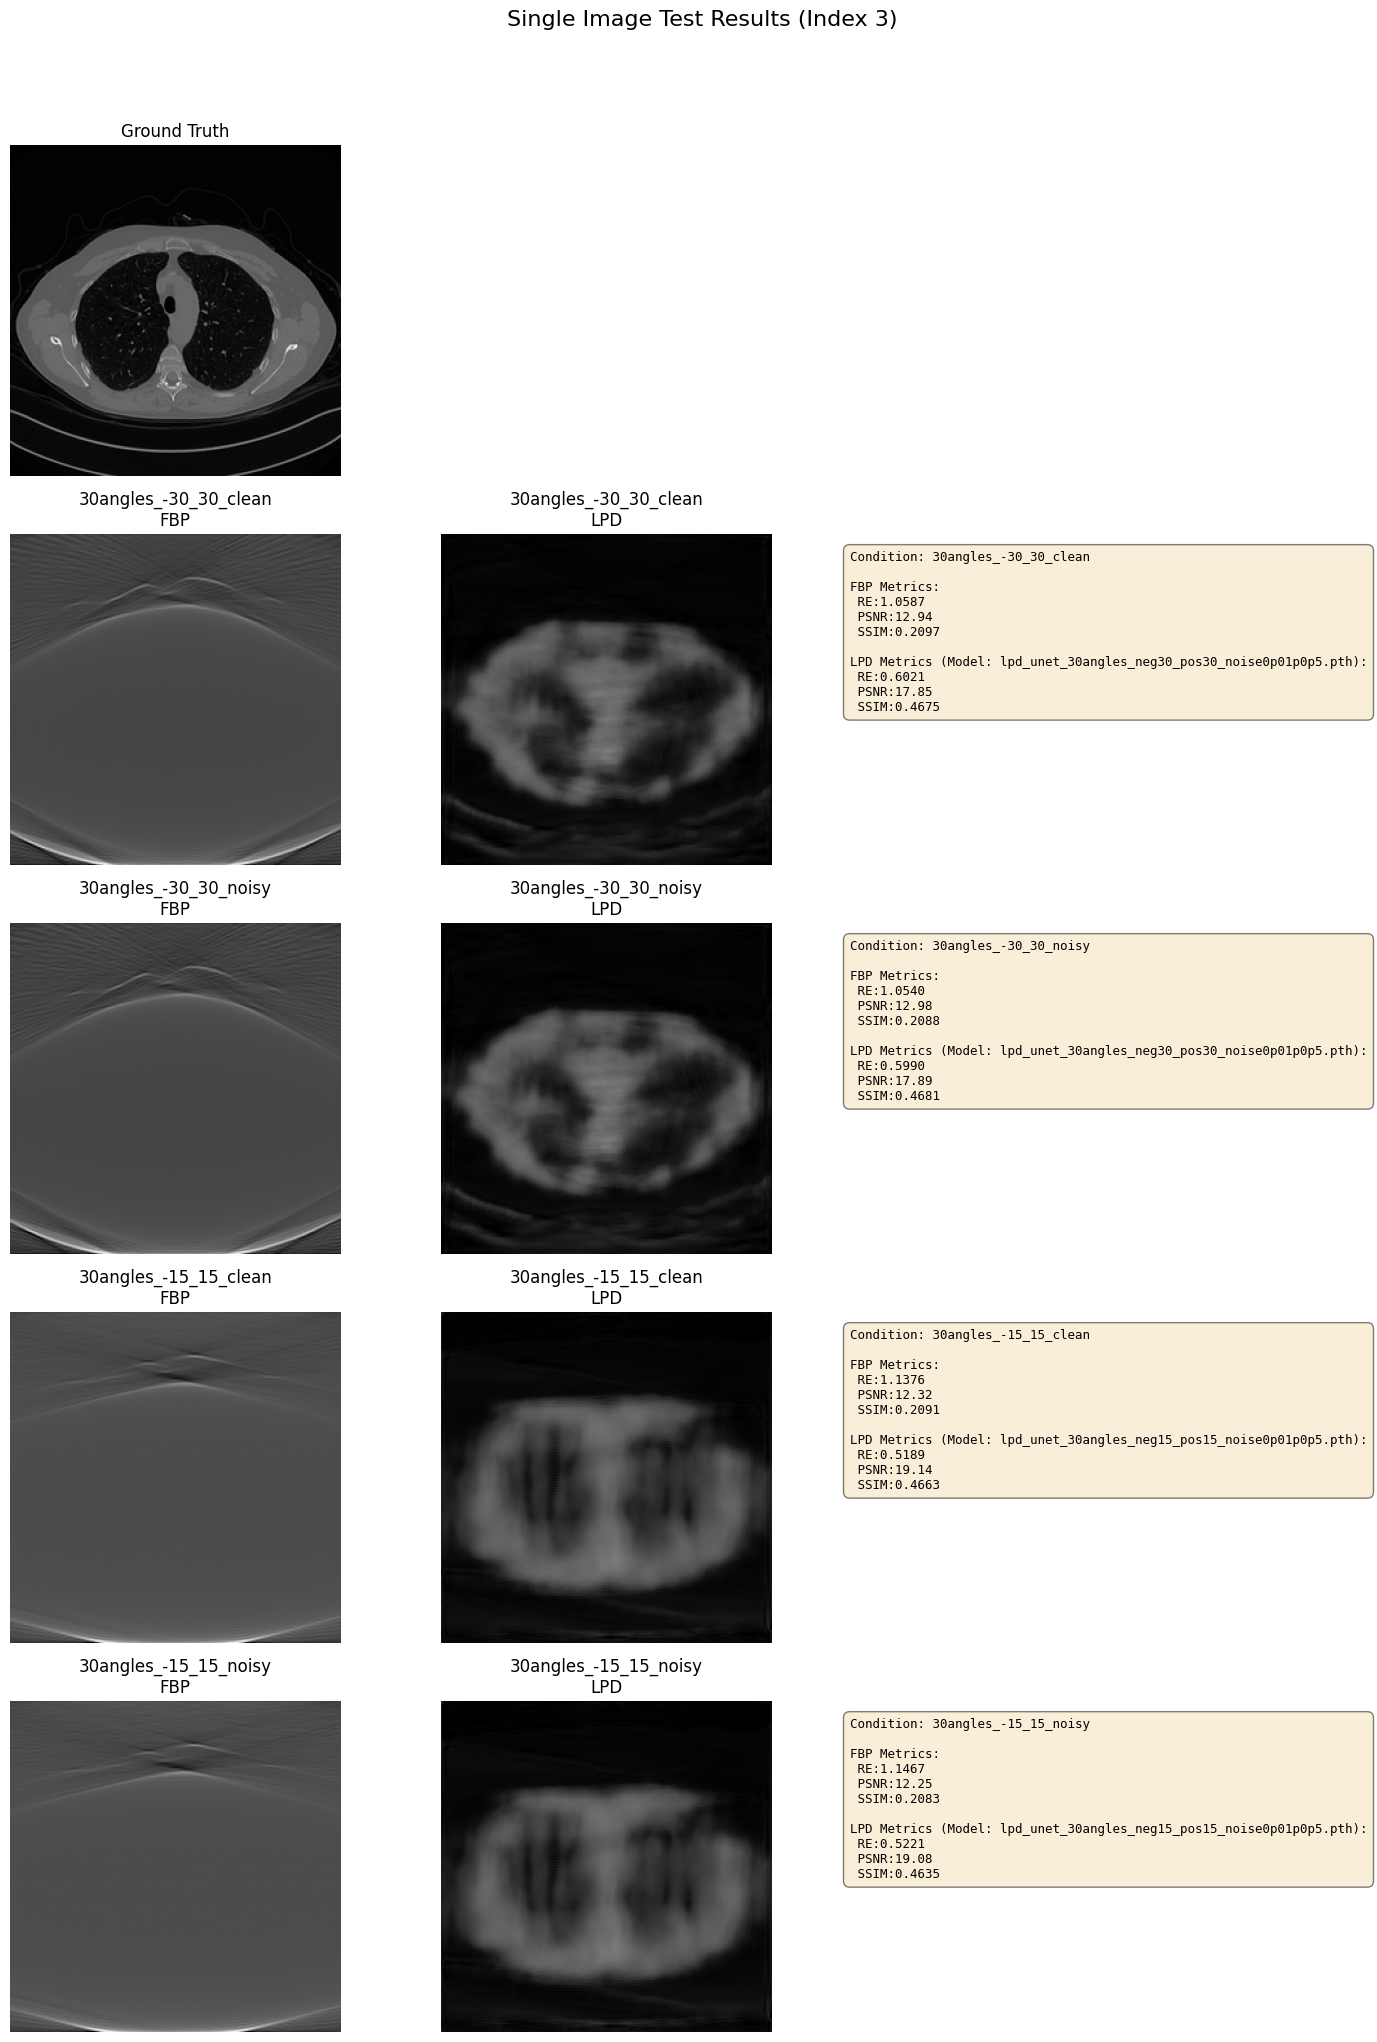

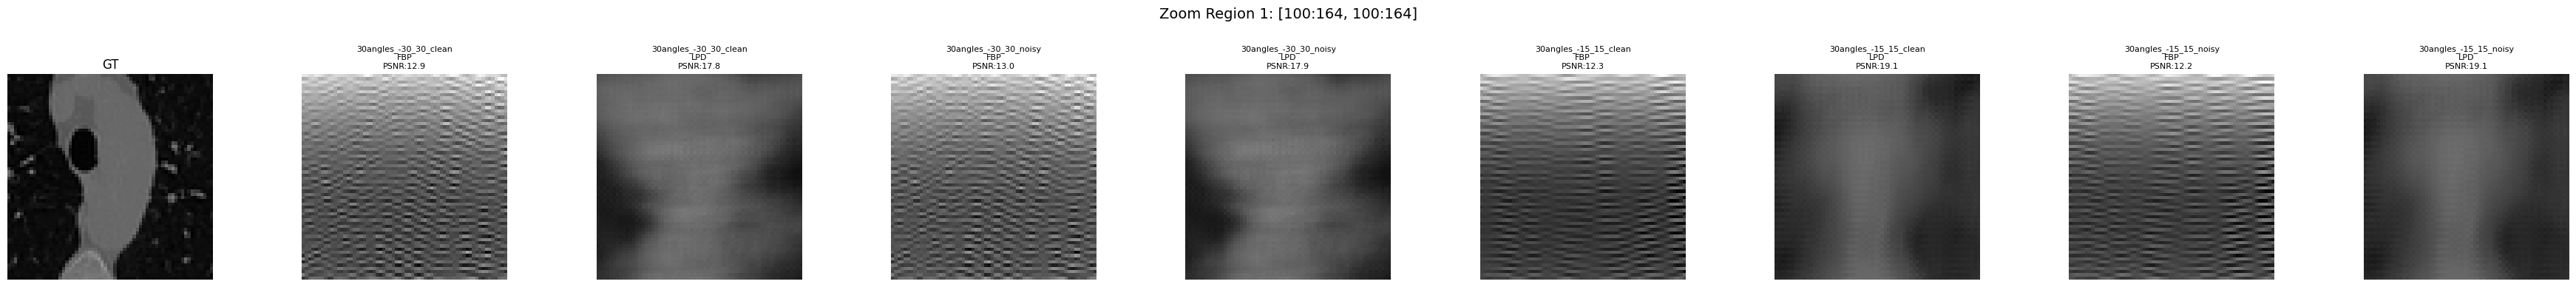

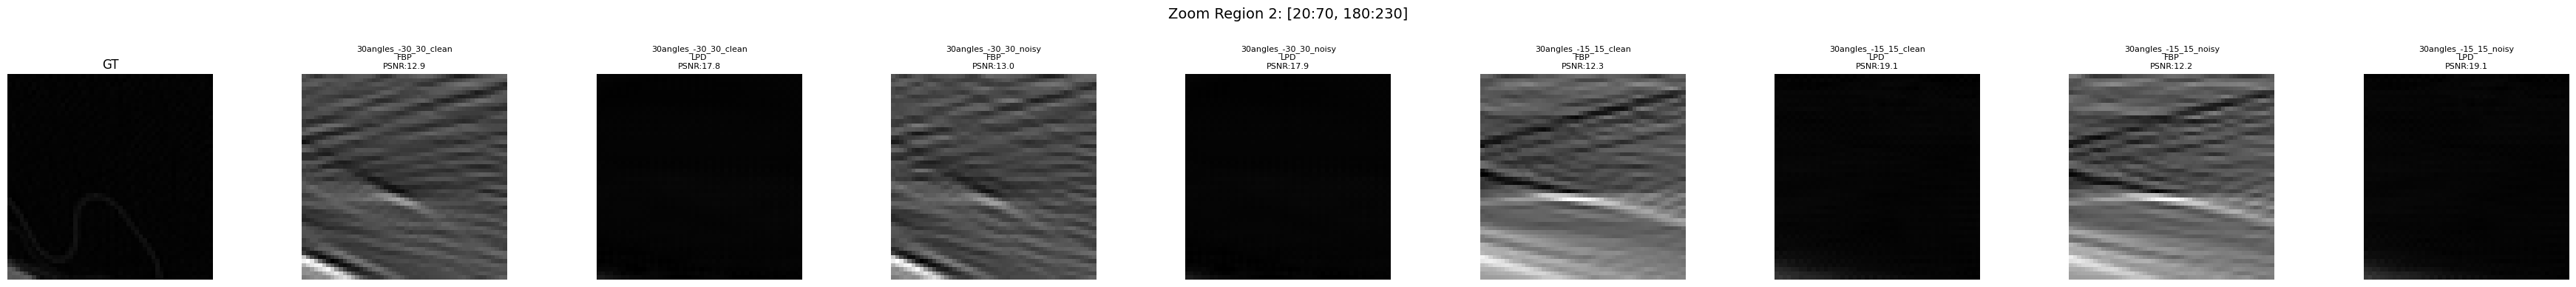


--- Running Full Dataset Average Metrics Test ---
Processed 327/327 batches (327 valid imgs). Avg time/img: 0.34s. ETA: 0.0 min.       
Finished processing 327 images in 111.80 seconds.

--- Average Metrics Across Full Test Dataset (327 images processed) ---
Model 1: lpd_unet_30angles_neg30_pos30_noise0p01p0p5.pth
Model 2: lpd_unet_30angles_neg15_pos15_noise0p01p0p5.pth
----------------------------------------------------
Test Condition Num Samples (LPD/FBP)  LPD RE  LPD PSNR  LPD SSIM  FBP RE  FBP PSNR  FBP SSIM
 model_1_clean               327/327  0.6675   17.3629    0.4601  1.1507   12.6969    0.2080
 model_1_noisy               327/327  0.6702   17.3304    0.4598  1.1531   12.6790    0.2069
 model_2_clean               327/327  0.6550   17.5580    0.4310  1.2475   12.0568    0.2062
 model_2_noisy               327/327  0.6553   17.5535    0.4304  1.2511   12.0345    0.2055

Inference script execution finished.


In [11]:
# -*- coding: utf-8 -*-
"""
Script di Inferenza e Valutazione per LPDNet Tomografica - VERSIONE MULTI-MODELLO

Questo script esegue i test richiesti caricando il modello specifico
per la geometria testata (low-angle o full-angle).

1. Testa su geometrie specifiche (30 angoli [-30,30], 180 angoli [-90,90]).
2. Testa con e senza rumore aggiunto (livello 0.01).
3. Calcola metriche RE, PSNR, SSIM.
4. Esegue Punto 3 (opzionale): visualizza risultati per una singola immagine
   per TUTTE E 4 le condizioni di test, usando il modello appropriato per ciascuna.
5. Esegue Punto 4 (opzionale): esegue test sull'intero dataset per TUTTE E 4
   le condizioni di test (usando il modello appropriato) e calcola medie in una tabella.

PREREQUISITI:
- File di checkpoint per ENTRAMBI i modelli LPDNet allenati (low-angle e full-angle).
- Dataset di test ('MajoDataset/test') con le immagini ground truth.
- DEFINIZIONI DELLE CLASSI: (Come prima) Devono essere disponibili
  (importate o copiate/incollate qui sotto).
"""



# =============================================================================
# 0. CONFIGURAZIONE DELL'INFERENZA <<-- MODIFICA QUI !!
# =============================================================================

# --- Specifiche dei Modelli Allenati da Caricare ---
# Devi fornire i parametri usati per allenare SIA il modello low-angle CHE full-angle,
# in modo che lo script possa trovare i rispettivi checkpoint.
# Assumiamo che entrambi siano stati allenati con lo stesso livello/probabilità di rumore,
# altrimenti dovresti rendere anche questi specifici per geometria.
COMMON_TRAINED_NOISE_LEVEL = 0.01  # Livello di rumore usato per allenare ENTRAMBI i modelli
COMMON_TRAINED_NOISE_PROB = 0.5   # Probabilità di rumore usata per allenare ENTRAMBI i modelli


NOISE_LEVEL_IF_APPLIED = 0.01


PROJ_MIN = 0.0
PROJ_MAX = 5.0  # Example maximum

# Calcolo dello standard deviation del rumore effettivo (usato QUANDO si aggiunge rumore)
NOISE_STD_DEV_ACTUAL = NOISE_LEVEL_IF_APPLIED * (PROJ_MAX - PROJ_MIN)



# --- Selezione Modalità di Esecuzione ---
# Imposta a True le modalità che vuoi eseguire. Puoi averle entrambe True.
RUN_SINGLE_IMAGE_DETAIL = True   # Esegue Punto 3
RUN_FULL_DATASET_AVG = True      # Esegue Punto 4

# --- Parametri per Punto 3 (se RUN_SINGLE_IMAGE_DETAIL = True) ---
SELECTED_IMAGE_INDEX = 3
ZOOM_REGIONS = [
    (100, 164, 100, 164),
    (20, 70, 180, 230)
]

# --- Parametri Generali ---
RECO_SIZE = 256
PROJ_MIN = 0.0
PROJ_MAX = 5.0
TEST_NOISE_FRACTION = 0.01

# Percorso base per cercare i checkpoint salvati
DRIVE_BASE_DIR = '/content/drive/MyDrive/Colab_Checkpoints'
DEFAULT_LOCAL_DIR = '.'


# =============================================================================
# --- INIZIO SCRIPT ---
# =============================================================================

# --- Monta Google Drive ---
drive_mounted = False
try:
    from google.colab import drive
    drive.mount('/content/drive'); drive_mounted = True; print("Drive montato.")
except: print("Drive non montato o errore. Cerco localmente.")

# --- Device Configuration ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Funzione per costruire path checkpoint ---
def get_checkpoint_path(geometry_mode, noise_level, noise_prob):
    if geometry_mode == 'low_angle': geometry_tag = "30angles_neg30_pos30"
    elif geometry_mode == 'full_angle': geometry_tag = "30angles_neg15_pos15"
    else: raise ValueError(f"Invalid geometry_mode: {geometry_mode}")
    noise_tag = f"noise{noise_level:.2f}p{noise_prob:.1f}".replace('.', 'p')
    config_name = f"{geometry_tag}_{noise_tag}"
    checkpoint_subdir = f'LPD_UNET_{config_name}'
    checkpoint_filename = f'lpd_unet_{config_name}.pth'
    path_drive = os.path.join(DRIVE_BASE_DIR, "LPD_UNET", checkpoint_subdir, checkpoint_filename)
    path_local = os.path.join(DEFAULT_LOCAL_DIR, "LPD_UNET", checkpoint_filename)

    if drive_mounted and os.path.exists(path_drive): return path_drive
    elif os.path.exists(path_local): return path_local
    else: return None # Non trovato

# --- Trova i percorsi per ENTRAMBI i modelli ---
CHECKPOINT_PATH_LOW = get_checkpoint_path('low_angle', COMMON_TRAINED_NOISE_LEVEL, COMMON_TRAINED_NOISE_PROB)
CHECKPOINT_PATH_FULL = get_checkpoint_path('full_angle', COMMON_TRAINED_NOISE_LEVEL, COMMON_TRAINED_NOISE_PROB)

if CHECKPOINT_PATH_LOW is None: print("!!! ERRORE: Checkpoint per 'low_angle' non trovato!"); exit()
if CHECKPOINT_PATH_FULL is None: print("!!! ERRORE: Checkpoint per 'full_angle' non trovato!"); exit()


# Definisci spazi e geometria ODL
reco_space = odl.uniform_discr(
    [-RECO_SIZE/2]*2, [RECO_SIZE/2]*2, [RECO_SIZE, RECO_SIZE], dtype='float32'
)


# Crea operatori ODL RayTransform e Adjoint
# Gestione backend ASTRA (CUDA preferito, poi CPU, poi fallback ODL)
try:
    ray_trafo_odl = odl.tomo.RayTransform(reco_space, geometry, impl='astra_cuda')
    print("Using ASTRA CUDA backend.")
except Exception as e_cuda:
    print(f"ASTRA CUDA backend failed ({e_cuda}), trying ASTRA CPU...")
    try:
        ray_trafo_odl = odl.tomo.RayTransform(reco_space, geometry, impl='astra_cpu')
        print("Using ASTRA CPU backend.")
    except Exception as e_cpu:
        print(f"ASTRA CPU backend failed ({e_cpu}), falling back to ODL default implementation.")
        ray_trafo_odl = odl.tomo.RayTransform(reco_space, geometry)

back_proj_odl = ray_trafo_odl.adjoint


back_proj = OperatorModule(back_proj_odl).to(device)



# =============================================================================
# FUNZIONI HELPER
# =============================================================================

def load_model(checkpoint_path, device):
    """Carica UN modello LPDNet da UN checkpoint."""
    print(f"Loading model weights from: {checkpoint_path}")
    # Definisci i parametri GLOBALI PRIMA di istanziare il modello.
    # !!! ASSUNZIONE CRITICA: Si assume che ENTRAMBI i modelli (low e full)
    # siano stati allenati con gli stessi iperparametri di rete (N_ITER, N_PRIMAL, etc.).
    # Se non è così, questa logica deve cambiare per caricare i parametri corretti
    # per ciascun modello, magari leggendoli dal checkpoint se salvati lì.
    global N_ITER, N_PRIMAL, N_DUAL, N_FEATURES, UNET_DEPTH, KERNEL_SIZE, RECO_SIZE
    N_ITER = 10
    N_PRIMAL = 5
    N_DUAL = 5
    KERNEL_SIZE = (3, 3)
    N_FEATURES = 4
    UNET_DEPTH = 1
    # Istanzia modello
    model = LearnedPrimalDualNet().to(device)
    try:
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        model.eval() # Modalità valutazione
        print(f"Model from {os.path.basename(checkpoint_path)} loaded successfully.")
        return model
    except Exception as e:
        print(f"!!! Error loading model state_dict from {checkpoint_path}: {e}"); exit()

# Le altre funzioni helper (define_odl_geometry, generate_sinogram,
# calculate_metrics, run_fbp, plot_results) rimangono INVARIATE rispetto
# alla versione precedente, poiché operano su dati passati come argomenti.

# Copio qui le funzioni helper per completezza
def define_odl_geometry(num_angles, angle_range_deg, reco_size):
    angle_min_rad = np.deg2rad(angle_range_deg[0]); angle_max_rad = np.deg2rad(angle_range_deg[1])
    detector_pixels = int(reco_size * np.sqrt(2))
    reco_space = odl.uniform_discr([-reco_size/2]*2, [reco_size/2]*2, [reco_size, reco_size], dtype='float32')
    angle_partition = odl.uniform_partition(angle_min_rad, angle_max_rad, num_angles)
    detector_partition = odl.uniform_partition(-detector_pixels/2, detector_pixels/2, detector_pixels)
    geometry = odl.tomo.Parallel2dGeometry(angle_partition, detector_partition)
    try: ray_trafo_odl = odl.tomo.RayTransform(reco_space, geometry, impl='astra_cuda')
    except:
         try: ray_trafo_odl = odl.tomo.RayTransform(reco_space, geometry, impl='astra_cpu')
         except: ray_trafo_odl = odl.tomo.RayTransform(reco_space, geometry)

    ray_trafo_module = OperatorModule(ray_trafo_odl).to(device)
    back_proj_odl = ray_trafo_odl.adjoint
    back_proj_module = OperatorModule(back_proj_odl).to(device)
    # print(f"Defined ODL geometry: {num_angles} angles [{angle_range_deg[0]}°, {angle_range_deg[1]}°]")
    return reco_space, geometry, ray_trafo_odl, back_proj_odl, ray_trafo_module, back_proj_module

def generate_sinogram(gt_image_np, ray_trafo_odl, reco_space, noise_std_dev=0.0, proj_min=0.0, proj_max=5.0):
    gt_image_np = np.clip(gt_image_np, 0.0, 1.0)
    odl_phantom = reco_space.element(gt_image_np.astype(np.float32))
    sinogram = ray_trafo_odl(odl_phantom).asarray().astype(np.float32)
    if noise_std_dev > 0: sinogram += np.random.normal(0, noise_std_dev, sinogram.shape).astype(np.float32)
    sg_min, sg_max = proj_min, proj_max
    if sg_max - sg_min < 1e-8: sinogram_normalized = np.zeros_like(sinogram)
    else: sinogram_normalized = (sinogram - sg_min) / (sg_max - sg_min)
    sinogram_normalized = np.clip(sinogram_normalized, 0.0, 1.0)
    if np.isnan(sinogram_normalized).any() or np.isinf(sinogram_normalized).any():
        print("WARN: NaN/Inf in generated sinogram."); sinogram_normalized = np.nan_to_num(sinogram_normalized, nan=0.0, posinf=1.0, neginf=0.0)
    return torch.from_numpy(sinogram_normalized).unsqueeze(0).unsqueeze(0)

def calculate_metrics(img_true, img_pred):
    assert img_true.shape == img_pred.shape; img_pred = np.clip(img_pred, 0.0, 1.0)
    norm_diff = np.linalg.norm(img_true - img_pred); norm_true = np.linalg.norm(img_true)
    re = norm_diff / norm_true if norm_true > 1e-8 else 0.0
    try: psnr_val = psnr(img_true, img_pred, data_range=1.0)
    except: psnr_val = -np.inf
    try:
        win_size = min(7, img_true.shape[0], img_true.shape[1]); win_size = max(3, win_size if win_size % 2 != 0 else win_size - 1)
        ssim_val = ssim(img_true, img_pred, data_range=1.0, channel_axis=None, win_size=win_size)
    except: ssim_val = -1.0
    return re, psnr_val, ssim_val

def run_fbp(sinogram_tensor, ray_trafo_odl, proj_min=0.0, proj_max=5.0, clip_output=True):
    sino_np_norm = sinogram_tensor.squeeze().cpu().numpy()
    sino_np_phys = sino_np_norm * (proj_max - proj_min) + proj_min
    sino_odl = ray_trafo_odl.range.element(sino_np_phys.astype(np.float32))
    try:
        fbp_op = odl.tomo.fbp_op(ray_trafo_odl, filter_type='Ram-Lak', frequency_scaling=0.8)
        fbp_recon = fbp_op(sino_odl).asarray()
        fbp_min, fbp_max = fbp_recon.min(), fbp_recon.max()
        if fbp_max - fbp_min > 1e-8: fbp_norm = (fbp_recon - fbp_min) / (fbp_max - fbp_min)
        else: fbp_norm = np.zeros_like(fbp_recon)
        if clip_output: fbp_norm = np.clip(fbp_norm, 0.0, 1.0)
        return fbp_norm
    except Exception as e: print(f"Error FBP: {e}"); return np.zeros(ray_trafo_odl.domain.shape, dtype=np.float32)

def plot_results(results_dict, title, zoom_regions):
    num_conditions = len(results_dict)
    n_cols = 3; n_rows = num_conditions + 1 # +1 for GT row
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows + 1), squeeze=False)
    fig.suptitle(title, fontsize=16, y=0.99) # Adjusted y slightly

    # Plot Ground Truth only once at the top
    # Get GT from the first available condition's results
    first_key = list(results_dict.keys())[0]
    gt = results_dict.get(first_key, {}).get('gt')
    if gt is not None:
        axes[0, 0].imshow(gt, cmap='gray', vmin=0, vmax=1)
        axes[0, 0].set_title("Ground Truth")
        axes[0, 0].axis('off')
    axes[0, 1].axis('off') # Empty space next to GT
    axes[0, 2].axis('off') # Empty space next to GT

    row_idx = 1 # Start plotting conditions from the second row
    for condition_name, results in results_dict.items():
        # <<< --- START MODIFICATION --- >>>
        # Get the display name, fallback to the original key
        display_name = results.get('display_name', condition_name)
        # <<< --- END MODIFICATION --- >>>

        fbp=results.get('fbp_recon'); lpd=results.get('lpd_recon');
        metrics_fbp=results.get('metrics_fbp'); metrics_lpd=results.get('metrics_lpd')
        ax_fbp=axes[row_idx, 0]; ax_lpd=axes[row_idx, 1]; ax_txt=axes[row_idx, 2]

        # Use display_name for titles
        if fbp is not None:
            ax_fbp.imshow(fbp, cmap='gray') # Removed vmin/vmax for FBP potentially
            ax_fbp.set_title(f"{display_name}\nFBP") # <<< USE display_name
            ax_fbp.axis('off')
        else: ax_fbp.axis('off')

        if lpd is not None:
            ax_lpd.imshow(lpd, cmap='gray', vmin=0, vmax=1)
            ax_lpd.set_title(f"{display_name}\nLPD") # <<< USE display_name
            ax_lpd.axis('off')
        else: ax_lpd.axis('off')

        ax_txt.axis('off')
        # Use display_name in text block
        text_content = f"Condition: {display_name}\n" # <<< USE display_name
        model_used = results.get('model_used', 'N/A')
        if metrics_fbp: text_content += f"\nFBP Metrics:\n RE:{metrics_fbp[0]:.4f}\n PSNR:{metrics_fbp[1]:.2f}\n SSIM:{metrics_fbp[2]:.4f}\n"
        if metrics_lpd: text_content += f"\nLPD Metrics (Model: {os.path.basename(model_used)}):\n RE:{metrics_lpd[0]:.4f}\n PSNR:{metrics_lpd[1]:.2f}\n SSIM:{metrics_lpd[2]:.4f}"
        ax_txt.text(0.05, 0.95, text_content, transform=ax_txt.transAxes, fontsize=9,
                    va='top', family='monospace', bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.5))

        row_idx += 1

    plt.tight_layout(rect=[0, 0.02, 1, 0.96]) # Adjust rect slightly for suptitle
    plt.show()

    # --- Zoom Plot Section ---
    if gt is not None and zoom_regions:
        for i, (y1, y2, x1, x2) in enumerate(zoom_regions):
            # Calculate number of columns needed: 1 (GT) + 2 * num_conditions (FBP+LPD for each)
            num_zoom_cols = 1 + 2 * num_conditions
            fig_zoom, axes_zoom = plt.subplots(1, num_zoom_cols, figsize=(4*num_zoom_cols, 4), squeeze=False)
            fig_zoom.suptitle(f"Zoom Region {i+1}: [{y1}:{y2}, {x1}:{x2}]", fontsize=14, y=0.98)

            # Plot GT zoom
            axes_zoom[0, 0].imshow(gt[y1:y2, x1:x2], cmap='gray', vmin=0, vmax=1)
            axes_zoom[0, 0].set_title("GT")
            axes_zoom[0, 0].axis('off')

            col_idx = 1 # Start plotting condition zooms from the second column
            for condition_name, results in results_dict.items():
                # <<< --- START MODIFICATION (Zoom) --- >>>
                display_name = results.get('display_name', condition_name)
                # <<< --- END MODIFICATION (Zoom) --- >>>

                fbp=results.get('fbp_recon'); lpd=results.get('lpd_recon');
                metrics_fbp=results.get('metrics_fbp',[-1]*3); metrics_lpd=results.get('metrics_lpd',[-1]*3) # Default metrics if missing

                # Plot FBP zoom (use display_name)
                if fbp is not None:
                    axes_zoom[0, col_idx].imshow(fbp[y1:y2, x1:x2], cmap='gray')
                    axes_zoom[0, col_idx].set_title(f"{display_name}\nFBP\nPSNR:{metrics_fbp[1]:.1f}", fontsize=8) # <<< USE display_name
                    axes_zoom[0, col_idx].axis('off')
                else: axes_zoom[0, col_idx].axis('off')
                col_idx += 1

                # Plot LPD zoom (use display_name)
                if lpd is not None:
                    axes_zoom[0, col_idx].imshow(lpd[y1:y2, x1:x2], cmap='gray', vmin=0, vmax=1)
                    axes_zoom[0, col_idx].set_title(f"{display_name}\nLPD\nPSNR:{metrics_lpd[1]:.1f}", fontsize=8) # <<< USE display_name
                    axes_zoom[0, col_idx].axis('off')
                else: axes_zoom[0, col_idx].axis('off')
                col_idx += 1

            plt.tight_layout(rect=[0, 0.02, 1, 0.92]) # Adjust rect slightly for suptitle
            plt.show()

# =============================================================================
# MAIN EXECUTION
# =============================================================================

# --- Carica ENTRAMBI i Modelli Allenati ---
print("\n--- Loading Trained Models ---")
# Assicurati che le definizioni delle classi siano state inserite/importate sopra!
lpd_model_low = load_model(CHECKPOINT_PATH_LOW, device)
lpd_model_full = load_model(CHECKPOINT_PATH_FULL, device)
print("----------------------------")

# --- Definisci Condizioni di Test (4 combinazioni) ---
test_conditions = {
    "model_1_clean":  {'angles': 30,  'range_deg': [-30, 30], 'noise_std': 0.0,                'model_to_use': lpd_model_low,  'model_path': CHECKPOINT_PATH_LOW},
    "model_1_noisy":  {'angles': 30,  'range_deg': [-30, 30], 'noise_std': NOISE_STD_DEV_ACTUAL, 'model_to_use': lpd_model_low,  'model_path': CHECKPOINT_PATH_LOW},
    "model_2_clean": {'angles': 30, 'range_deg': [-15, 15], 'noise_std': 0.0,                'model_to_use': lpd_model_full, 'model_path': CHECKPOINT_PATH_FULL}, # <<-- Assicurati che gli angoli e il range siano corretti per model_2
    "model_2_noisy": {'angles': 30, 'range_deg': [-15, 15], 'noise_std': NOISE_STD_DEV_ACTUAL, 'model_to_use': lpd_model_full, 'model_path': CHECKPOINT_PATH_FULL}, # <<-- Assicurati che gli angoli e il range siano corretti per model_2
}
print(f"Defined Test Conditions: {list(test_conditions.keys())}")

# --- Carica Dataset di Test ---
# Usa la geometria e operatore TEMPORANEI solo per l'init del Dataset
test_data_dir = os.path.join('MajoDataset','test') # Assicurati che il path sia corretto
if not os.path.isdir(test_data_dir): raise FileNotFoundError(f"Test data directory not found: {test_data_dir}")
print(f"Initializing Dataset with temporary operator: {ray_trafo_odl}")
test_ds = MayoPngDataset(test_data_dir, reco_space, ray_trafo_odl, # Passa l'op temporaneo
                         noise_probability=COMMON_TRAINED_NOISE_PROB, # Passa anche gli altri args richiesti da __init__
                         noise_std_dev=NOISE_STD_DEV_ACTUAL, # Anche se poi useremo noise_std dalle 'test_conditions'
                         proj_min=PROJ_MIN, proj_max=PROJ_MAX, reco_size=RECO_SIZE)

if len(test_ds) == 0: raise ValueError("Test dataset is empty or failed to load.")
# Il DataLoader userà la collate_fn definita che gestisce le tuple
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=0, collate_fn=collate_skip_none)
print(f"Test dataset loaded: {len(test_ds)} images found.")

# --- ESECUZIONE PUNTO 3: IMMAGINE SINGOLA (Usa Modello Corretto) ---
if RUN_SINGLE_IMAGE_DETAIL:
    print(f"\n--- Running Single Image Detail Test (Index: {SELECTED_IMAGE_INDEX}) ---")
    if SELECTED_IMAGE_INDEX >= len(test_ds):
        print(f"!!! Error: SELECTED_IMAGE_INDEX out of range.")
    else:
        try:
            # Recupera la TUPLE (sino, gt) dal dataset
            sample_tuple = test_ds[SELECTED_IMAGE_INDEX]
            if sample_tuple is None:
                 raise ValueError(f"Failed to load image {SELECTED_IMAGE_INDEX}")

            # Estrai SOLO il tensore GT dalla tupla (è il secondo elemento)
            # Il sinogramma nella tupla (sample_tuple[0]) viene ignorato qui,
            # perché ne genereremo uno nuovo per ogni condizione di test.
            gt_tensor_single = sample_tuple[1]

            # Converti GT in numpy (ora gt_tensor_single è un tensore)
            gt_np_single = gt_tensor_single.squeeze().cpu().numpy() # Aggiunto .cpu() per sicurezza
            print(f"Loaded GT image shape: {gt_np_single.shape}")

            # Verifica forma GT
            if gt_np_single.shape != (RECO_SIZE, RECO_SIZE):
                print(f"WARN: Expected GT shape {(RECO_SIZE, RECO_SIZE)}, but got {gt_np_single.shape}. Resizing might be needed or check dataset.")
                # Potrebbe essere necessario un resize qui se il dataset non lo fa correttamente
                # gt_np_single = np.array(Image.fromarray(gt_np_single).resize((RECO_SIZE, RECO_SIZE), Image.Resampling.LANCZOS))

            single_image_results = {}

            # Itera sulle 4 condizioni di test
            for condition_name, params in test_conditions.items():
                print(f"\nProcessing Condition: {condition_name} for single image...")
                current_model = params['model_to_use']
                current_model_path = params['model_path']
                print(f"  Using model: {os.path.basename(current_model_path)}")

                # <<< --- START NEW CODE --- >>>
                # Generate the desired display name
                angle_tag = f"{params['angles']}angles_{int(params['range_deg'][0])}_{int(params['range_deg'][1])}"
                noise_tag = "clean" if params['noise_std'] == 0.0 else "noisy"
                display_name = f"{angle_tag}_{noise_tag}"
                # <<< --- END NEW CODE --- >>>

                # 1. Definisci geometria ODL e OTTIENI I MODULI OPERATORI CORRETTI
                reco_space_test, geometry_test, ray_trafo_odl_test, back_proj_odl_test, \
                ray_trafo_module_test, back_proj_module_test = define_odl_geometry(
                    params['angles'], params['range_deg'], RECO_SIZE
                )
                print(f"   Defined test geometry: {params['angles']} angles [{params['range_deg'][0]}°, {params['range_deg'][1]}°]")

                # 2. Genera sinogramma test
                sinogram_test_tensor = generate_sinogram(
                    gt_np_single, ray_trafo_odl_test, reco_space_test,
                    noise_std_dev=params['noise_std'],
                    proj_min=PROJ_MIN, proj_max=PROJ_MAX
                ).to(device)
                print(f"   Generated test sinogram shape: {sinogram_test_tensor.shape}")

                # 3. Inferenza LPD
                start_time = time.time()
                with torch.no_grad():
                    lpd_recon_tensor = current_model(sinogram_test_tensor,
                                                     ray_trafo_module_test,
                                                     back_proj_module_test)
                lpd_time = time.time() - start_time
                lpd_recon_np = torch.clamp(lpd_recon_tensor, 0.0, 1.0).squeeze().cpu().numpy()
                print(f"   LPD Inference time: {lpd_time:.3f} s, Output shape: {lpd_recon_np.shape}")

                # 4. FBP
                start_time = time.time()
                fbp_recon_np = run_fbp(sinogram_test_tensor, ray_trafo_odl_test, proj_min=PROJ_MIN, proj_max=PROJ_MAX)
                fbp_time = time.time() - start_time
                print(f"   FBP Reconstruction time: {fbp_time:.3f} s, Output shape: {fbp_recon_np.shape}")

                # 5. Metriche
                if gt_np_single.shape != lpd_recon_np.shape: print(f"WARN: Shape mismatch GT {gt_np_single.shape} vs LPD {lpd_recon_np.shape}"); continue
                if gt_np_single.shape != fbp_recon_np.shape: print(f"WARN: Shape mismatch GT {gt_np_single.shape} vs FBP {fbp_recon_np.shape}"); continue

                metrics_lpd = calculate_metrics(gt_np_single, lpd_recon_np)
                metrics_fbp = calculate_metrics(gt_np_single, fbp_recon_np)
                print(f"  Metrics LPD (RE, PSNR, SSIM): {metrics_lpd[0]:.4f}, {metrics_lpd[1]:.2f}, {metrics_lpd[2]:.4f}")
                print(f"  Metrics FBP (RE, PSNR, SSIM): {metrics_fbp[0]:.4f}, {metrics_fbp[1]:.2f}, {metrics_fbp[2]:.4f}")

                # 6. Salva risultati (INCLUDE display_name)
                single_image_results[condition_name] = {
                    'gt': gt_np_single, 'lpd_recon': lpd_recon_np, 'fbp_recon': fbp_recon_np,
                    'metrics_lpd': metrics_lpd, 'metrics_fbp': metrics_fbp,
                    'model_used': current_model_path,
                    'display_name': display_name # <<< --- STORE THE NEW NAME --- >>>
                }
            # 7. Visualizza (dopo aver processato tutte le condizioni per l'immagine)
            if single_image_results: # Controlla se ci sono risultati da plottare
                 plot_title = f"Single Image Test Results (Index {SELECTED_IMAGE_INDEX})"
                 plot_results(single_image_results, plot_title, ZOOM_REGIONS)
            else:
                 print("No results generated for single image test.")

        except Exception as e: print(f"!!! Error during single image test: {e}"); import traceback; traceback.print_exc()


# --- ESECUZIONE PUNTO 4: MEDIA SU TUTTO IL DATASET (Usa Modello Corretto) ---
if RUN_FULL_DATASET_AVG:
    print(f"\n--- Running Full Dataset Average Metrics Test ---")
    all_metrics = {name: {'lpd_re': [], 'lpd_psnr': [], 'lpd_ssim': [], 'fbp_re': [], 'fbp_psnr': [], 'fbp_ssim': []} for name in test_conditions}
    num_images_processed = 0; image_processing_times = []
    total_start_time = time.time()

    # Itera sulle immagini: il loader ritorna batch di tuple: (batch_sino, batch_gt)
    for i, batch_data in enumerate(test_loader):
        batch_start_time = time.time()
        if batch_data is None:
            print(f"Skipping empty batch {i}.")
            continue # Batch vuoto a causa di errori filtrati

        # Estrai il batch di GT dalla tupla (è il secondo elemento)
        gt_batch = batch_data[1]

        # Estrai il singolo tensore GT dal batch (assumendo batch_size=1)
        if gt_batch.shape[0] != 1:
             print(f"WARN: Expected batch size 1, but got {gt_batch.shape[0]} for GT batch. Processing only first element.")
             # Potresti voler gestire batch > 1 o dare errore
        gt_tensor_single = gt_batch[0] # Prende il primo elemento del batch GT


        # Converti in numpy
        gt_np_single = gt_tensor_single.squeeze().cpu().numpy() # Questo è ora il GT corretto (RECO_SIZE, RECO_SIZE)
        print(f"Processing image {i+1}/{len(test_ds)}... GT shape: {gt_np_single.shape}", end='\r')
        if gt_np_single.shape != (RECO_SIZE, RECO_SIZE): continue # Skip immagine se shape errata

        # Verifica forma GT anche qui
        if gt_np_single.shape != (RECO_SIZE, RECO_SIZE):
            print(f"\nWARN: Image {i+1}: Expected GT shape {(RECO_SIZE, RECO_SIZE)}, got {gt_np_single.shape}. Skipping this image.")
            continue

        # Itera sulle condizioni di test
        for condition_name, params in test_conditions.items():
            # SELEZIONA MODELLO CORRETTO
            current_model = params['model_to_use']

            reco_space_test, geometry_test, ray_trafo_odl_test, back_proj_odl_test, \
                ray_trafo_module_test, back_proj_module_test = define_odl_geometry( # <-- Scompatta i nuovi valori
                    params['angles'], params['range_deg'], RECO_SIZE
                )

            # 2. Genera sinogramma test (usa GT corretto e geometria/rumore specifici)
            sinogram_test_tensor = generate_sinogram(
                gt_np_single, # GT numpy 2D
                ray_trafo_odl_test, # Usa l'operatore ODL corretto
                reco_space_test, # Spazio della geometria test
                noise_std_dev=params['noise_std'],
                proj_min=PROJ_MIN, proj_max=PROJ_MAX
            ).to(device)

            # 3. Inferenza LPD (PASSA I MODULI OPERATORI CORRETTI)
            lpd_recon_np = None # Inizializza a None
            try:
                with torch.no_grad():
                    lpd_recon_tensor = current_model(sinogram_test_tensor,
                                                      ray_trafo_module_test, # <-- Passa operatore K
                                                      back_proj_module_test) # <-- Passa operatore K*
                lpd_recon_np = torch.clamp(lpd_recon_tensor, 0.0, 1.0).squeeze().cpu().numpy()
            except Exception as lpd_err:
                print(f"\nERROR during LPD inference for img {i+1}, condition {condition_name}: {lpd_err}. Skipping LPD.")
                # Non impostare lpd_recon_np = None qui, è già None

            # 4. FBP (Usa l'operatore ODL corretto)
            fbp_recon_np = None # Inizializza a None
            try:
                fbp_recon_np = run_fbp(sinogram_test_tensor, ray_trafo_odl_test, proj_min=PROJ_MIN, proj_max=PROJ_MAX)
            except Exception as fbp_err:
                print(f"\nERROR during FBP for img {i+1}, condition {condition_name}: {fbp_err}. Skipping FBP.")
                # Non impostare fbp_recon_np = None qui, è già None


            # 5. Calcola e accumula metriche (SOLO se le ricostruzioni sono valide)
            try:
                metrics_lpd, metrics_fbp = (np.nan, np.nan, np.nan), (np.nan, np.nan, np.nan) # Default a NaN
                valid_lpd = lpd_recon_np is not None and lpd_recon_np.shape == gt_np_single.shape
                valid_fbp = fbp_recon_np is not None and fbp_recon_np.shape == gt_np_single.shape

                if valid_lpd:
                     metrics_lpd = calculate_metrics(gt_np_single, lpd_recon_np)
                     all_metrics[condition_name]['lpd_re'].append(metrics_lpd[0])
                     all_metrics[condition_name]['lpd_psnr'].append(metrics_lpd[1])
                     all_metrics[condition_name]['lpd_ssim'].append(metrics_lpd[2])
                else: # Appendi NaN se LPD non è valido
                     all_metrics[condition_name]['lpd_re'].append(np.nan)
                     all_metrics[condition_name]['lpd_psnr'].append(np.nan)
                     all_metrics[condition_name]['lpd_ssim'].append(np.nan)


                if valid_fbp:
                     metrics_fbp = calculate_metrics(gt_np_single, fbp_recon_np)
                     all_metrics[condition_name]['fbp_re'].append(metrics_fbp[0])
                     all_metrics[condition_name]['fbp_psnr'].append(metrics_fbp[1])
                     all_metrics[condition_name]['fbp_ssim'].append(metrics_fbp[2])
                else: # Appendi NaN se FBP non è valido
                     all_metrics[condition_name]['fbp_re'].append(np.nan)
                     all_metrics[condition_name]['fbp_psnr'].append(np.nan)
                     all_metrics[condition_name]['fbp_ssim'].append(np.nan)

            except Exception as metric_err:
                 print(f"\nWARN: Metric calculation failed: Img {i+1}, Cond {condition_name}. Err: {metric_err}")
                 # Appendi NaN se c'è un errore nel calcolo stesso
                 if valid_lpd: all_metrics[condition_name]['lpd_re'].append(np.nan); all_metrics[condition_name]['lpd_psnr'].append(np.nan); all_metrics[condition_name]['lpd_ssim'].append(np.nan)
                 if valid_fbp: all_metrics[condition_name]['fbp_re'].append(np.nan); all_metrics[condition_name]['fbp_psnr'].append(np.nan); all_metrics[condition_name]['fbp_ssim'].append(np.nan)

        # Fine loop condizioni
        num_images_processed += 1 # Incrementa DOPO aver processato tutte le condizioni per l'immagine
        image_processing_times.append(time.time() - batch_start_time)
        if (i+1) % 20 == 0 or (i+1) == len(test_loader): # Stampa ETA e all'ultima immagine
            avg_time_per_image = np.mean(image_processing_times) if image_processing_times else 0
            remaining_batches = len(test_loader)-(i+1)
            eta_seconds = remaining_batches*avg_time_per_image
            eta_minutes = eta_seconds/60
            print(f"Processed {i+1}/{len(test_loader)} batches ({num_images_processed} valid imgs). Avg time/img: {avg_time_per_image:.2f}s. ETA: {eta_minutes:.1f} min.       ", end='\r')

    # Fine loop immagini
    total_time = time.time() - total_start_time
    print(f"\nFinished processing {num_images_processed} images in {total_time:.2f} seconds.")

    # --- Calcola e Stampa Medie in Tabella ---
    avg_results = []
    print(f"\n--- Average Metrics Across Full Test Dataset ({num_images_processed} images processed) ---")
    print(f"Model 1: {os.path.basename(CHECKPOINT_PATH_LOW)}")
    print(f"Model 2: {os.path.basename(CHECKPOINT_PATH_FULL)}")
    print("----------------------------------------------------")

    for condition_name, metrics in all_metrics.items():
        # Filtra NaN prima di calcolare la media
        valid_lpd_re   = [r for r in metrics['lpd_re']   if np.isfinite(r)]
        valid_lpd_psnr = [p for p in metrics['lpd_psnr'] if np.isfinite(p)]
        valid_lpd_ssim = [s for s in metrics['lpd_ssim'] if np.isfinite(s)]
        valid_fbp_re   = [r for r in metrics['fbp_re']   if np.isfinite(r)]
        valid_fbp_psnr = [p for p in metrics['fbp_psnr'] if np.isfinite(p)]
        valid_fbp_ssim = [s for s in metrics['fbp_ssim'] if np.isfinite(s)]

        # Conteggia campioni validi per ogni metrica (potrebbero differire se alcuni calcoli falliscono)
        num_valid_lpd = len(valid_lpd_re) # Assumiamo che se RE è valido, gli altri lo sono (o sono NaN)
        num_valid_fbp = len(valid_fbp_re)

        if num_valid_lpd == 0 and num_valid_fbp == 0:
             print(f"Condition: {condition_name} - No valid results.")
             continue

        avg_results.append({
            "Test Condition": condition_name,
            "Num Samples (LPD/FBP)": f"{num_valid_lpd}/{num_valid_fbp}", # Mostra quanti campioni validi per LPD/FBP
            "LPD RE": np.mean(valid_lpd_re) if valid_lpd_re else np.nan,
            "LPD PSNR": np.mean(valid_lpd_psnr) if valid_lpd_psnr else np.nan,
            "LPD SSIM": np.mean(valid_lpd_ssim) if valid_lpd_ssim else np.nan,
            "FBP RE": np.mean(valid_fbp_re) if valid_fbp_re else np.nan,
            "FBP PSNR": np.mean(valid_fbp_psnr) if valid_fbp_psnr else np.nan,
            "FBP SSIM": np.mean(valid_fbp_ssim) if valid_fbp_ssim else np.nan,
        })
    if avg_results:
        df = pd.DataFrame(avg_results)
        pd.set_option('display.precision', 4)
        pd.set_option('display.max_rows', None)
        pd.set_option('display.max_columns', None) # Mostra tutte le colonne
        pd.set_option('display.width', 200) # Larghezza output
        print(df.to_string(index=False, na_rep='NaN')) # Rappresenta NaN esplicitamente
    else: print("No average results could be calculated.")


# --- Messaggio Finale ---
if not RUN_SINGLE_IMAGE_DETAIL and not RUN_FULL_DATASET_AVG:
    print("\nNessuna modalità di esecuzione selezionata.")
print("\nInference script execution finished.")